In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[2]  # or resolve explicitly
sys.path.insert(0, str(PROJECT_ROOT))
print(PROJECT_ROOT)

/home/x_tagty/equivariant-posteriors


In [2]:
# DEbugging
import time
import os

# Set BEFORE importing numpy/xarray
# print(
# os.environ["OMP_NUM_THREADS"], #= "64"  # Max for your OpenBLAS
# os.environ["OPENBLAS_NUM_THREADS"], #= "64"
# os.environ["MKL_NUM_THREADS"], #= "64"
# os.environ["NUMEXPR_NUM_THREADS"], #= "64"
# )


KeyError: 'OMP_NUM_THREADS'

In [2]:
import torch
import numpy as np
from pathlib import Path

#import onnxruntime as ort

from lib.train_dataclasses import TrainConfig
from lib.train_dataclasses import TrainRun
from lib.train_dataclasses import TrainEval
from lib.train_dataclasses import OptimizerConfig
from lib.train_dataclasses import ComputeConfig
from lib.metric import create_metric

from experiments.weather.models.swin_hp_pangu_pad import SwinHPPanguPadConfig

from lib.distributed_trainer import distributed_train

# from experiments.weather.data import DataHP
from experiments.weather.data import DataHPConfig #, Climatology
# from experiments.weather.models.swin_hp_pangu import SwinHPPangu

# from lib.models.mlp import MLPConfig
from lib.ddp import ddp_setup
from lib.ensemble import create_ensemble_config
from lib.ensemble import create_ensemble
from lib.ensemble import request_ensemble
from lib.ensemble import symlink_checkpoint_files
from lib.ensemble import is_ensemble_serialized
from lib.files import prepare_results

from lib.data_factory import get_factory as get_dataset_factory

/uv/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[Compute environment] paths: 
[Paths] checkpoints: /proj/heal_pangu/eqp_climate/checkpoints (/proj/heal_pangu/eqp_climate/checkpoints)
[Paths] locks: locks (/home/x_tagty/equivariant-posteriors/experiments/climate/notebooks/locks)
[Paths] distributed_requests: distributed_requests (/home/x_tagty/equivariant-posteriors/experiments/climate/notebooks/distributed_requests)
[Paths] artifacts: /proj/heal_pangu/eqp_climate/artifacts (/proj/heal_pangu/eqp_climate/artifacts)
[Paths] datasets: /proj/heal_pangu/datasets (/proj/heal_pangu/datasets)


In [3]:
# requires to install eofs and gpytorch
import xarray as xr
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
#import gpytorch
import os
import glob
#from eofs.xarray import Eof

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from typing import Dict, Optional, List, Callable, Tuple, Union

#import wandb
#from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Load multiple samples

In [4]:
import healpix
def interpolate_dh_to_hp(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(lat=xlat, lon=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image

def interpolate_dh_to_hp_output(nside, variable: xr.DataArray):
    """
    Input is xr.DataArray 
    """
    
    npix = healpix.nside2npix(nside)
    hlong, hlat = healpix.pix2ang(nside, np.arange(0, npix, 1), lonlat=True, nest=True)
    hlong = np.mod(hlong, 360)
    xlong = xr.DataArray(hlong, dims="z")
    xlat = xr.DataArray(hlat, dims="z")

    xhp = variable.interp(y=xlat, x=xlong, kwargs={"fill_value": None})
    hp_image = np.array(xhp.to_numpy(), dtype=np.float32) # ! removed to_array()
    return hp_image


def get_input_paths(exp, input_dir, fire_type):
    input_gasses = {
    "BC":  "BC_sum",
    "CH4": "CH4_sum",
    "SO2": "SO2_sum",
    "CO2": "CO2_sum",
    }
    gas_files = {g: [] for g in gas_patterns}
    for gas, folder_name in input_gasses.items():
        var_dir = os.path.join(input_dir, exp, folder_name, "250_km", "mon")
        files = glob.glob(var_dir + "/**/*.nc", recursive=True)
    
        for f in files:
            if folder_name in f and (gas == "CO2" or fire_type in f): # CO2 does not have fire_type
                gas_files[gas].append(f)
    #print(gas_files["BC"])
    # Check same len
    for k, v in gas_files.items():
        print(k, len(v))

    return gas_files

def get_output_paths(exp, target_dir, mod, ensembles, variables):
    var_file_dict = {v: [] for v in variables}
    for var in variables:
        var_dir = os.path.join(target_dir, mod, ensembles, exp, var, '250_km', 'mon')
        var_files = glob.glob(var_dir + '/**/*.nc', recursive=True)
        #var_file_dict[var].append(var_files)
        for f in var_files:
            var_file_dict[var].append(f)

    return var_file_dict

def get_hp_dataset(files : dict, nside : int, output : bool = False):
    hp_gas_dict = {}
    #print(files)
    for var, var_files in files.items():

        
        # ds = xr.open_mfdataset(var_files, concat_dim="time", combine="nested")
        # this required dask, which is not currently in constructed apptainer

        datasets = [xr.open_dataset(f) for f in var_files]
        ds = xr.concat(datasets, dim="time").sortby("time")
        
        ds = ds.sortby("time")
        arr = ds.to_array().squeeze("variable") # remove var dim since 1

        if output:
            hp = interpolate_dh_to_hp_output(nside, arr)
        else:
            hp = interpolate_dh_to_hp(nside, arr)
        # print(type(hp))
        hp_gas_dict[var] = hp

    return hp_gas_dict

import healpy
def healpix_plotting(hp_data, data_shift=0, norm=None, nest=True, flip="geo", title=None):
    data = hp_data + data_shift
    healpy.visufunc.cartview(data, nest=nest, norm=norm, title=title, flip=flip)
    #healpy.visufunc.orthview(data, nest=nest, norm=norm)
    #healpy.visufunc.mollview(data, nest=nest, norm=norm)
    #healpy.visufunc.gnomview(data, nest=nest, norm=norm)

HEALPIX TEST


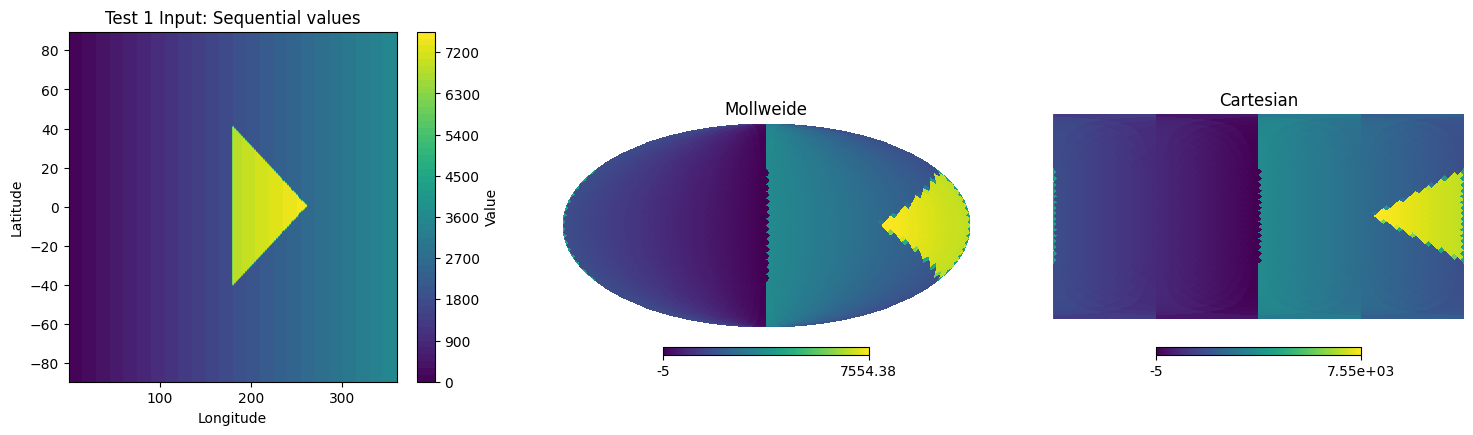

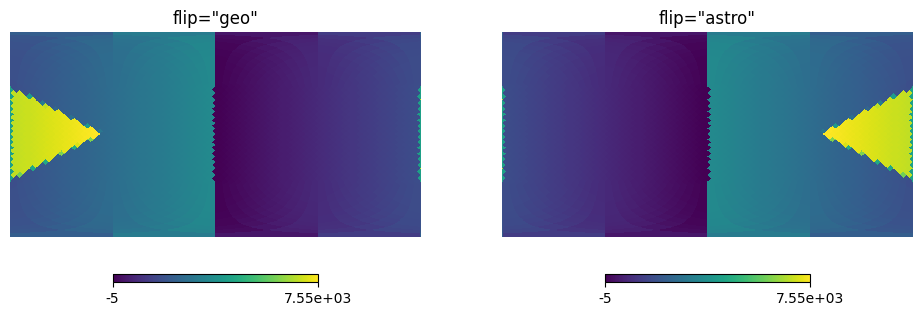

/tmp/ipykernel_719261/977813542.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

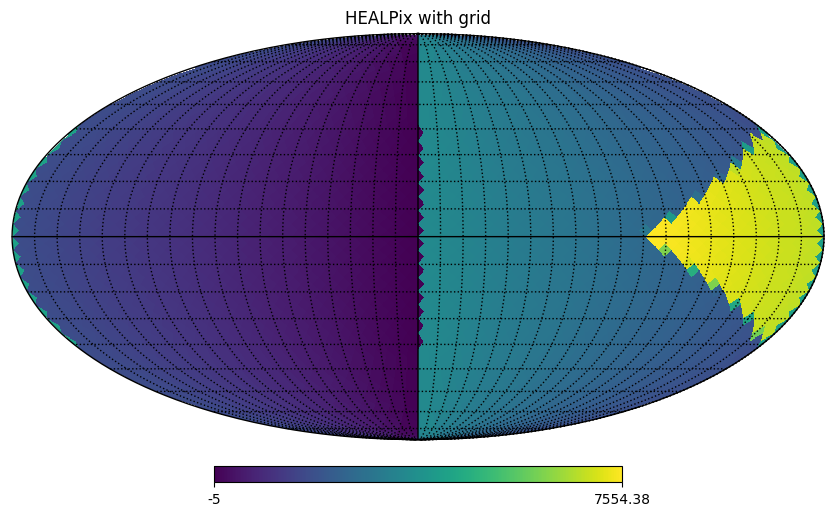

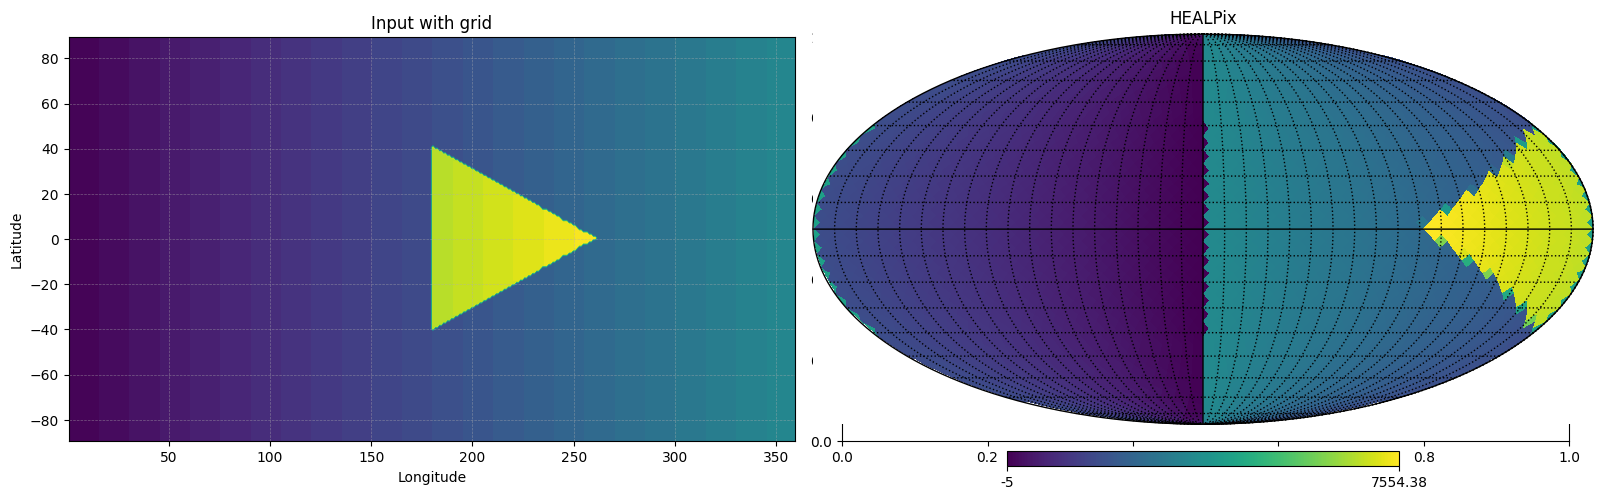

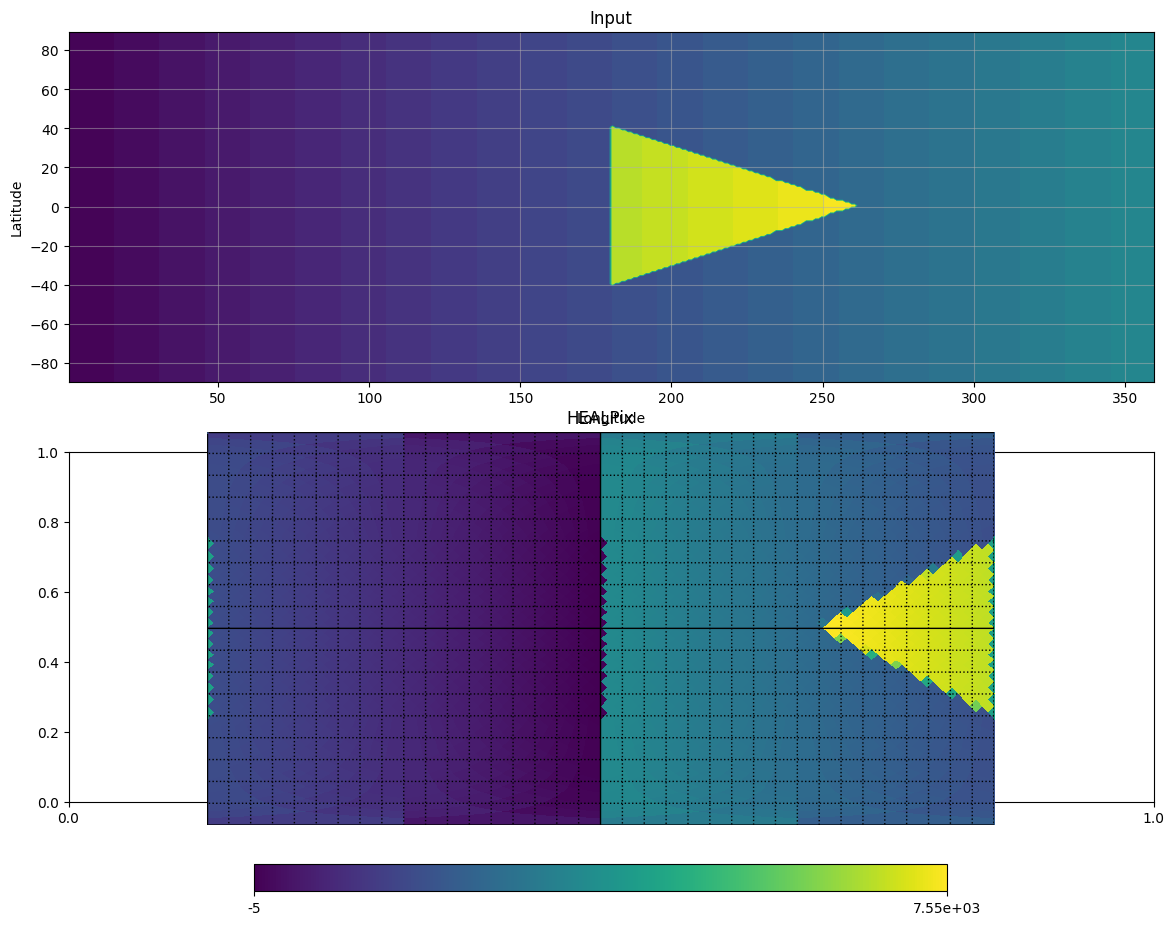

In [9]:
import numpy as np
import xarray as xr
import healpix
import healpy
import matplotlib.pyplot as plt

def create_simple_test_data3():
    nlat = 180
    nlon = 360
    lats = np.linspace(-89.5, 89.5, nlat)
    lons = np.linspace(0.5, 359.5, nlon)

    lon_values = np.arange(nlon) * 10
    values = np.tile(lon_values, (nlat, 1)).astype(float)
    
    # Create an asymmetric triangle pointing to the right
    lat_idx = np.arange(nlat)[:, None]
    lon_idx = np.arange(nlon)[None, :]
    
    lat_center = nlat // 2
    lon_center = nlon // 2
    
    height = 40   # vertical half-size
    width = 80    # horizontal extent (to the right)
    
    triangle_mask = (
        (lon_idx >= lon_center) &
        (lon_idx <= lon_center + width) &
        (np.abs(lat_idx - lat_center) <=
         (height * (1 - (lon_idx - lon_center) / width)))
    )
    
    # Increase values inside the triangle
    values[triangle_mask] += 5000
    
    data = xr.DataArray(
        values,
        coords={'lat': lats, 'lon': lons},
        dims=['lat', 'lon'],
        name='test_data_with_triangle'
    )
    return data

def test_healpix_function():
    """
    Test your function with simple data
    """
    print("HEALPIX TEST")
    print("=" * 70)
    nside = 16

    data = create_simple_test_data3()
    hp_data = interpolate_dh_to_hp(nside, data)
    
    fig = plt.figure(figsize=(18, 10))
    
    plt.subplot(2, 3, 1)
    plt.contourf(data.lon, data.lat, data.values, levels=50, cmap='viridis')
    plt.title('Test 1 Input: Sequential values')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Value')
    
    plt.subplot(2, 3, 2)
    healpy.mollview(hp_data, nest=True, title='Mollweide', 
                    hold=True, cmap='viridis', sub=(2, 3, 2))
    
    plt.subplot(2, 3, 3)
    healpy.cartview(hp_data, nest=True, title='Cartesian',
                    hold=True, cmap='viridis', sub=(2, 3, 3))
    
    # try with flip parameter
    fig2 = plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    healpy.cartview(hp_data, nest=True, title='flip="geo"',
                    hold=True, cmap='viridis', flip='geo', sub=(1, 3, 1))
    
    plt.subplot(1, 3, 2)
    healpy.cartview(hp_data, nest=True, title='flip="astro"',
                    hold=True, cmap='viridis', flip='astro', sub=(1, 3, 2))

    plt.show()

    
    # Option 1: Add grid lines to HEALPix plot
    fig = plt.figure(figsize=(12, 6))
    healpy.mollview(hp_data, nest=True, title='HEALPix with grid', cmap='viridis')
    
    # Add latitude/longitude grid lines
    healpy.graticule(dpar=10, dmer=10, coord='C', verbose=False)
    #plt.savefig('/mnt/user-data/outputs/healpix_with_grid.png', dpi=150)
    
    
    # Option 2: Side-by-side with matching grids
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Input data with grid
    axes[0].contourf(data.lon, data.lat, data.values, levels=50, cmap='viridis')
    axes[0].grid(True, alpha=0.5, linestyle='--', linewidth=0.5)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title('Input with grid')
    
    # HEALPix in second subplot, then add grid separately
    healpy.mollview(hp_data, nest=True, cmap='viridis', sub=(1, 2, 2), title='HEALPix')
    healpy.graticule(dpar=10, dmer=10)  # 10 degree grid
    
    #plt.tight_layout()
    #plt.savefig('/mnt/user-data/outputs/side_by_side_grids.png', dpi=150)
    
    
    # Option 3: Cartesian view with grid (easier to compare with input)
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    axes[0].contourf(data.lon, data.lat, data.values, levels=50, cmap='viridis')
    axes[0].grid(True, alpha=0.5)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title('Normal only why')
    
    healpy.cartview(hp_data, nest=True, cmap='viridis', sub=(2, 1, 2), title='HEALPix')
    healpy.graticule(dpar=10, dmer=10)


    return hp_data #, hp_markers



hp_data = test_healpix_function()

## Preprocessing functions

In [28]:
def transform_batch_inputs(data, stats, gas_vars, eps=1e-12):
    """
    Transform input data with per-channel normalization.
    data: (B, C, N) where C is number of gas channels
    """
    transformed = np.zeros_like(data)
    
    for i, var in enumerate(gas_vars):
        channel_data = data[:, i, :]  # (B, N)
        
        if stats[var]['use_log']:
            # Log transform for gases
            channel_data = np.log10(np.clip(channel_data, 1e-15, None) + 1e-15)
        
        # Standardize
        mean = stats[var]['mean']
        std = max(stats[var]['std'], eps)
        transformed[:, i, :] = (channel_data - mean) / std
    
    return transformed

def transform_batch_outputs(data, stats, output_vars, eps=1e-12):
    """
    Transform output data with per-channel normalization.
    data: (B, C, N) where C is number of output channels
    """
    transformed = np.zeros_like(data)
    
    for i, var in enumerate(output_vars):
        channel_data = data[:, i, :]  # (B, N)
        
        if stats[var]['use_log']:
            channel_data = np.log10(np.clip(channel_data, 1e-15, None) + 1e-15)
        
        # Standardize
        mean = stats[var]['mean']
        std = max(stats[var]['std'], eps)
        transformed[:, i, :] = (channel_data - mean) / std
    
    return transformed

def preprocess_batch(batch, input_stats, output_stats, input_vars, output_vars):
    """
    Preprocessing pipeline for a batch.
    """
    x_batch = batch['input']  # (B, C_in, N)
    y_batch = batch['output']  # (B, C_out, N)
    
    # 1. Check for NaNs or Infs
    if np.any(np.isnan(x_batch)) or np.any(np.isinf(x_batch)):
        print("WARNING: NaN/Inf in input data")
    
    if np.any(np.isnan(y_batch)) or np.any(np.isinf(y_batch)):
        print("WARNING: NaN/Inf in output data")
    
    # Per-channel normalization
    x_transformed = transform_batch_inputs(x_batch, input_stats, input_vars)
    y_transformed = transform_batch_outputs(y_batch, output_stats, output_vars)
    
    # Could clip to prevent extreme outliers
    # x_transformed = np.clip(x_transformed, -10, 10)
    # y_transformed = np.clip(y_transformed, -10, 10)
    
    return x_transformed, y_transformed

## Load data 

In [29]:
datapath = "/proj/heal_pangu/users/x_tagty/climateset"
input_dir = os.path.join(datapath, "inputs", "input4mips")
target_dir = os.path.join(datapath, "outputs", "CMIP6")

fire_type = 'all-fires'
output_vars = ['tas', "pr"]

mod = 'CAS-ESM2-0'
ensembles = 'r3i1p1f1' 
experiments = ["ssp585", "ssp126", "ssp370"]
#experiments = [train_experiments[0]]
#input_gases = ['BC_sum', 'CH4_sum', 'CO2_sum', 'SO2_sum']
gas_patterns = {
    "BC":  "BC_sum",
    "CH4": "CH4_sum",
    "SO2": "SO2_sum",
    "CO2": "CO2_sum",
}

nside = 32
experiment_input_dict = {}
experiment_output_dict = {}
for exp in experiments:
    input_paths = get_input_paths(exp, input_dir, fire_type)
    print("got input paths")
    hp_input_dict = get_hp_dataset(input_paths, nside)
    print("hp input done")
    # TODO : Add concatenate or similar if multiple experiments
    experiment_input_dict[exp] = hp_input_dict
    
    print("checking outputs")
    output_paths = get_output_paths(exp, target_dir, mod, ensembles, output_vars)
    print("got output paths")
    hp_target_dict = get_hp_dataset(output_paths, nside, output=True)
    # TODO : Add concatenate or similar  if multiple experiments
    experiment_output_dict[exp] = hp_target_dict

BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths
BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths
BC 86
CH4 86
SO2 86
CO2 86
got input paths
hp input done
checking outputs
got output paths


## Create manual batches

In [30]:
def prepare_manual_batches(experiment_input_dict, experiment_output_dict, 
                           gas_vars=['BC', 'CH4', 'SO2', 'CO2'],
                           output_vars=["tas", "pr"],
                           batch_size=8):
    """
    Manually create batches without using DataLoader.
    Returns a list of (input_batch, output_batch) tuples.
    """
    all_inputs = []
    all_outputs = []
    all_metadata = []

    # Collect all samples
    for exp in experiment_input_dict.keys():
        n_timesteps = experiment_input_dict[exp][gas_vars[0]].shape[0]
        
        for t in range(n_timesteps):
            # Stack input channels
            input_channels = [experiment_input_dict[exp][var][t] for var in gas_vars]
            input_data = np.stack(input_channels, axis=0)  # (C, N)
            all_inputs.append(input_data)
            
            # Stack output channels (if doing supervised learning)
            if experiment_output_dict and exp in experiment_output_dict:
                output_channels = [experiment_output_dict[exp][var][t] for var in output_vars]
                output_data = np.stack(output_channels, axis=0)
                all_outputs.append(output_data)
            
            all_metadata.append({'exp': exp, 'time': t})
    
    # Convert to numpy arrays
    all_inputs = np.array(all_inputs)  # (N_samples, C, N_pixels)
    if all_outputs:
        all_outputs = np.array(all_outputs)
    
    # Create batches
    n_samples = len(all_inputs)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    batches = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        batch_input = all_inputs[start_idx:end_idx]
        batch_output = all_outputs[start_idx:end_idx] # if all_outputs else None
        batch_meta = all_metadata[start_idx:end_idx]
        
        batches.append({
            'input': batch_input,
            'output': batch_output,
            'metadata': batch_meta,
            'batch_idx': i
        })
    
    return batches, all_inputs, all_outputs


def apply_log_transform(data, global_mean=None, global_std=None, eps=1e-12):
    """Apply log10 transform and normalization"""
    data_log = np.log10(np.clip(data, 1e-15, None) + 1e-15)
    
    if global_mean is not None and global_std is not None:
        data_scaled = (data_log - global_mean) / max(global_std, eps)
    else:
        data_scaled = (data_log - data_log.mean()) / max(data_log.std(), eps)
    
    return data_scaled

In [31]:
def compute_per_channel_statistics(experiment_dict, gas_vars, log_transform=False, plot=False):
    """
    Compute mean and std for each channel separately.
    Returns dict with stats for each variable.
    """
    stats = {}
    
    for var in gas_vars:
        all_values = []
        for exp in experiment_dict.keys():
            data = experiment_dict[exp][var]
            # Log transform for gases (very small values)
            
            if var in ['BC', 'CH4', 'SO2', 'CO2'] and log_transform:
                data_log = np.log10(np.clip(data, 1e-15, None) + 1e-15)
                all_values.append(data_log.flatten())
            else:
                all_values.append(data.flatten()) # No log for temperature/other outputs
        
        all_values = np.concatenate(all_values)
        stats[var] = {
            'mean': np.mean(all_values),
            'std': np.std(all_values),
            'use_log': var in ['BC', 'CH4', 'SO2', 'CO2']
        }
        print(f"{var}: mean={stats[var]['mean']:.6f}, std={stats[var]['std']:.6f}, log={stats[var]['use_log']}")
        if plot:
            plt.title(f"{exp}: {var}")
            plt.hist(all_values, bins=50)
            plt.show()
            if var in ['BC', 'CH4', 'SO2', 'CO2'] and not log_transform:
                plt.title(f"{exp}: {var} log-transformed")
                plt.hist(np.log10(np.clip(all_values, 1e-15, None) + 1e-15), bins=50)
                plt.show()
    
            z_norm = (all_values - np.mean(all_values)) / np.std(all_values)
            plt.title(f"{exp}: {var} z-normed")
            plt.hist(z_norm, bins=50)
            plt.show()

    return stats

def compute_per_channel_statistics_linear_z(
    experiment_dict,
    gas_vars,
    plot=False,
    bins=30,
):
    stats = {}

    for var in gas_vars:
        all_values = []

        for exp in experiment_dict.keys():
            data = experiment_dict[exp][var]
            all_values.append(data.flatten())

        all_values = np.concatenate(all_values)

        mean = np.mean(all_values)
        std = np.std(all_values)

        stats[var] = {
            "mean": mean,
            "std": std,
            "use_log": False
        }

        print(f"{var}: mean={mean:.6e}, std={std:.6e}, log=False")
        if plot:
            # Raw distribution
            plt.figure()
            plt.title(f"{var} raw")
            plt.hist(all_values, bins=50)
            plt.show()
    
            # Z-scored distribution
            z = (all_values - mean) / std
            print("z mean", np.mean(z))
            print("z std", np.std(z))
            plt.figure()
            plt.title(f"{var} standardized")
            plt.hist(z, bins=bins)
            plt.show()

            # Z-scored distribution
            z = (all_values - mean) / std
            plt.figure()
            plt.title(f"{var} standardized, log scale")
            plt.hist(z, bins=bins, log=True)
            plt.show()

    return stats

In [32]:
input_vars = ['BC', 'CH4', 'SO2', 'CO2']
output_vars = ["tas", "pr"]
batch_size = 64

# 1. Prepare batches manually
print("Preparing batches...")
batches, all_inputs, all_outputs = prepare_manual_batches(
    experiment_input_dict, 
    experiment_output_dict,
    gas_vars= input_vars,
    output_vars = output_vars,
    batch_size=batch_size
)

Preparing batches...


BC: mean=4.257747e-13, std=1.950174e-12, log=False


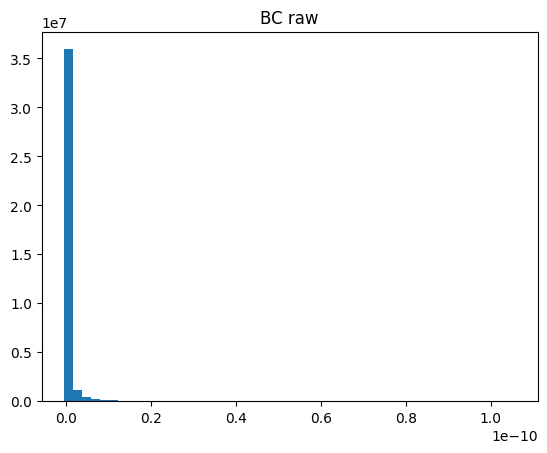

z mean -1.2052806e-07
z std 0.9999992


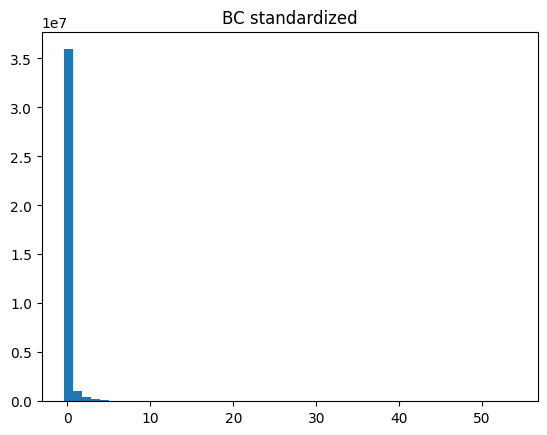

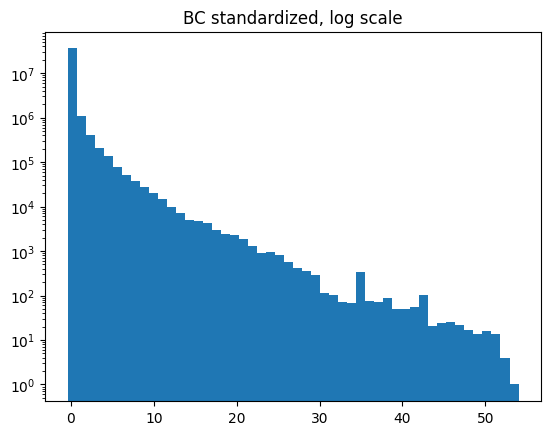

CH4: mean=2.619591e-11, std=1.110291e-10, log=False


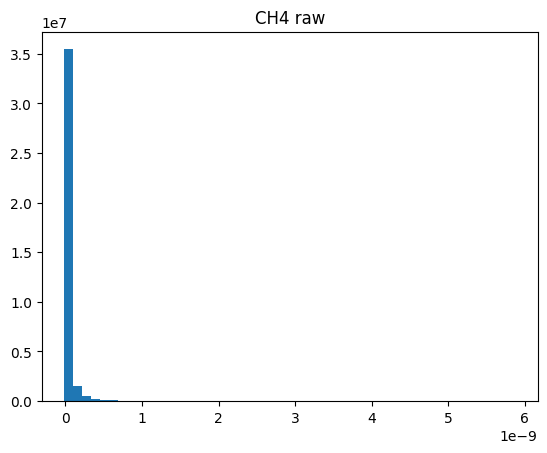

z mean -3.7217607e-08
z std 0.9999997


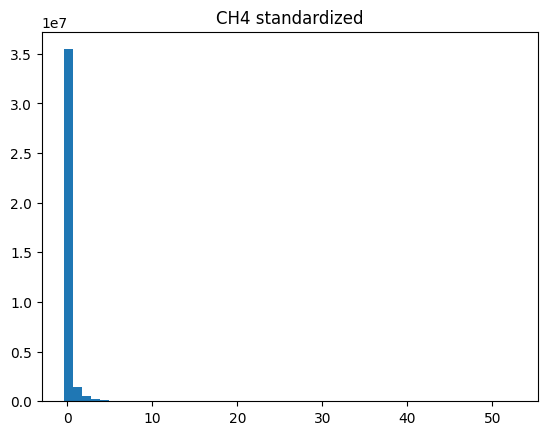

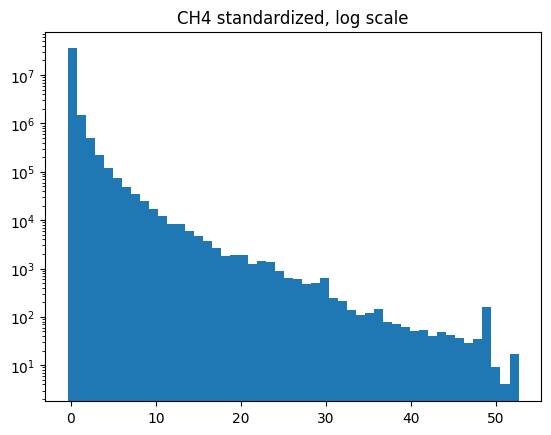

SO2: mean=3.759943e-12, std=2.810924e-11, log=False


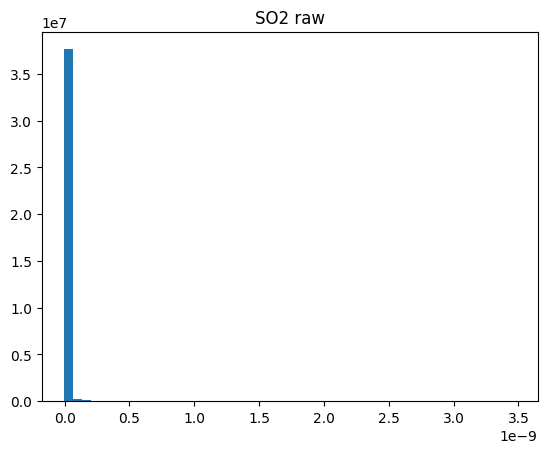

z mean 2.756029e-07
z std 1.000001


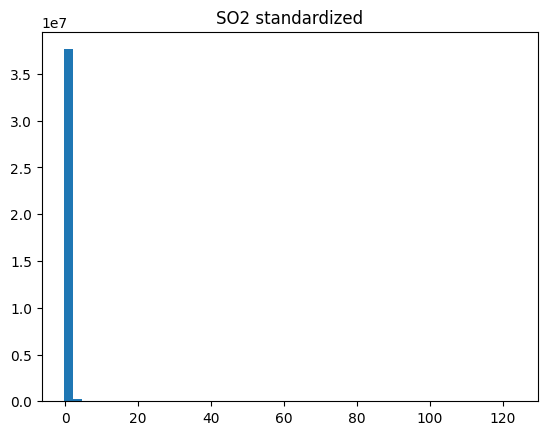

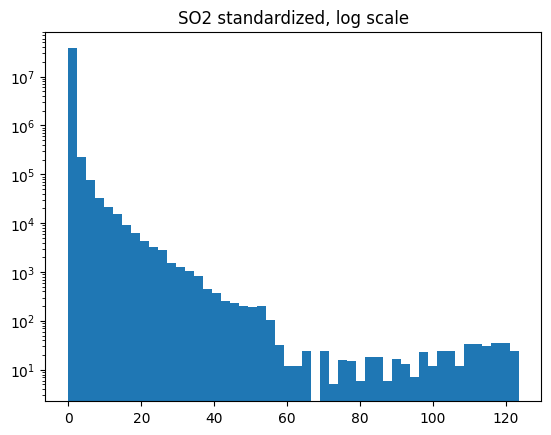

CO2: mean=3.401347e-09, std=2.430766e-08, log=False


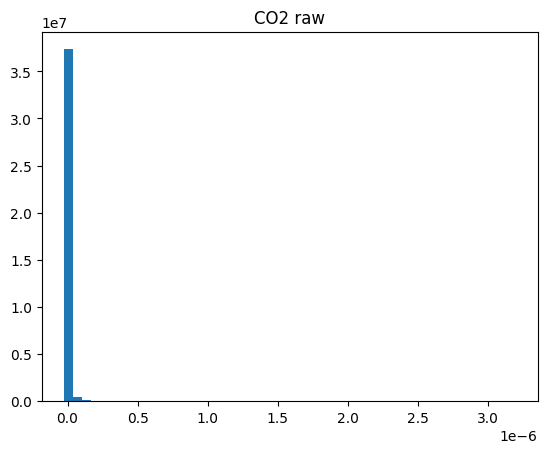

z mean -7.746181e-08
z std 0.99999946


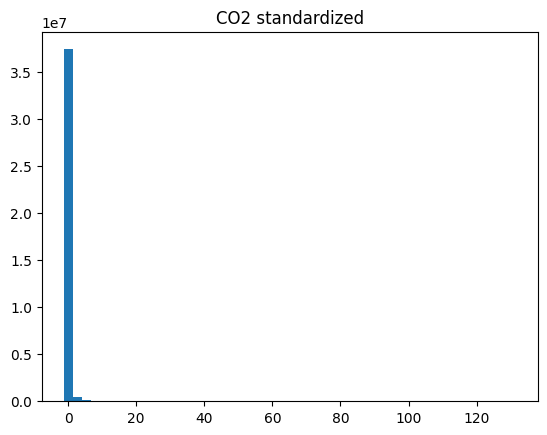

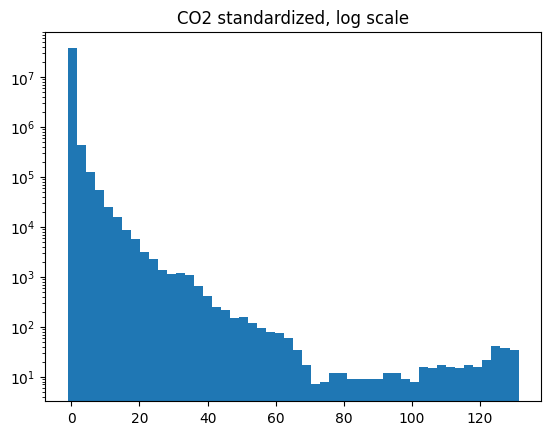

tas: mean=2.895970e+02, std=1.507672e+01, log=False


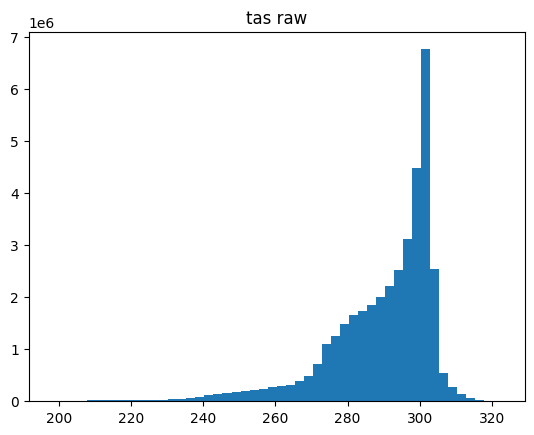

z mean -1.1307537e-05
z std 1.0000012


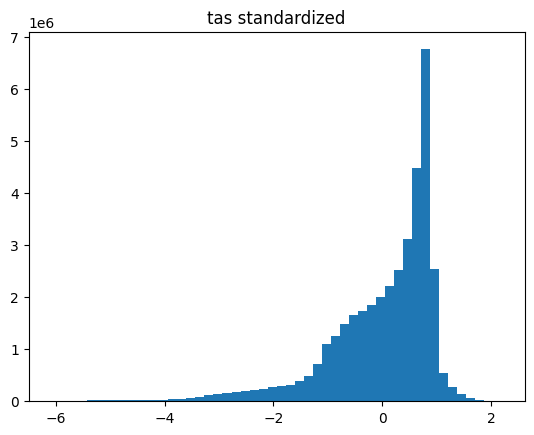

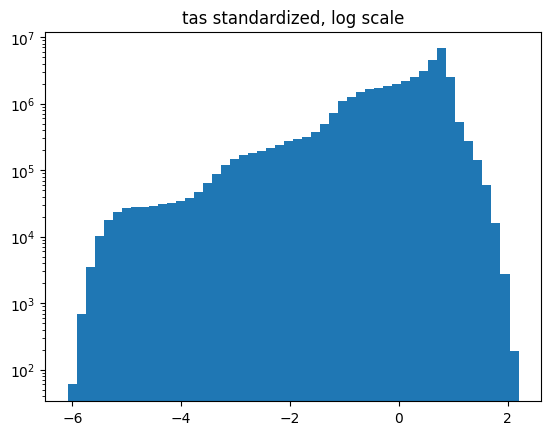

pr: mean=3.338883e-05, std=3.312870e-05, log=False


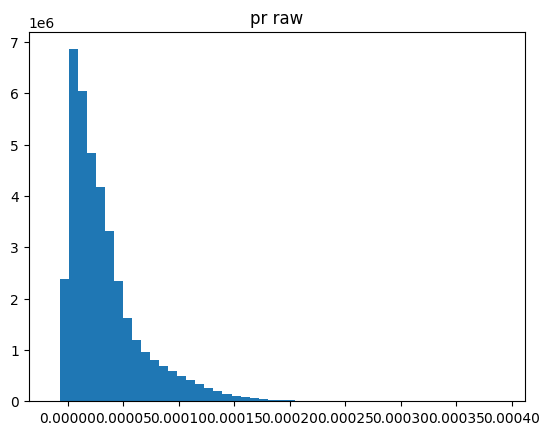

z mean -1.1826401e-06
z std 0.9999998


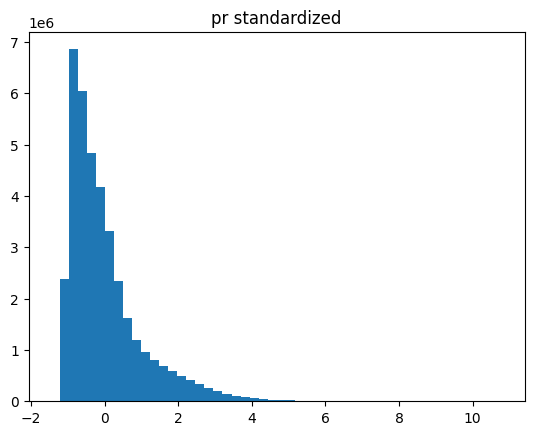

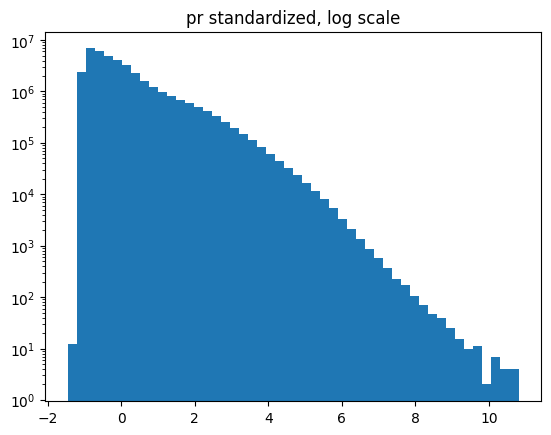

In [33]:
bins = 50
input_stats = compute_per_channel_statistics_linear_z(experiment_input_dict, input_vars, plot=True, bins=bins)
output_stats = compute_per_channel_statistics_linear_z(experiment_output_dict, output_vars, plot=True, bins=bins)
#output_stats = compute_per_channel_statistics(experiment_output_dict, output_vars, log_transform=True)

In [34]:
test_experiments = ["ssp245"]
test_input_dict = {}
test_output_dict = {}

for exp in test_experiments:
    input_paths = get_input_paths(exp, input_dir, fire_type)
    hp_input_dict = get_hp_dataset(input_paths, nside)
    test_input_dict[exp] = hp_input_dict
    
    output_paths = get_output_paths(exp, target_dir, mod, ensembles, output_vars)
    hp_target_dict = get_hp_dataset(output_paths, nside, output=True)
    test_output_dict[exp] = hp_target_dict

# Prepare test batches
test_batches, test_inputs, test_outputs = prepare_manual_batches(
    test_input_dict, 
    test_output_dict,
    gas_vars=input_vars,
    output_vars=output_vars,
    batch_size=batch_size
)

BC 86
CH4 86
SO2 86
CO2 86


## Overfit single sample test
Remember to change the data loading for this if you want to revert back to one channel !

In [40]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=1, n_upper=1)  # 1 output temperature

learning_rate = 3e-3
model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)


# Get first sample from first batch
single_batch = {
    'input': batches[0]['input'][0:1],   # (1, 4, N) - just first sample
    'output': batches[0]['output'][0:1], # (1, 1, N) - just first sample
}

# Fresh optimizer for this test
model.train()
test_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
test_criterion = torch.nn.MSELoss()

print(f"Input shape: {single_batch['input'].shape}")
print(f"Output shape: {single_batch['output'].shape}")
metric_list = []
# Try to overfit for 200 steps
n_steps = 5000
for step in range(n_steps):
    # Preprocess
    x_transformed, y_transformed = preprocess_batch(
        single_batch, input_stats, output_stats, input_vars, output_vars
    )
    
    x_tensor = torch.from_numpy(x_transformed).float().to(device)
    y_true = torch.from_numpy(y_transformed).float().to(device)
    
    # Forward
    test_optimizer.zero_grad()
    out = model({"input_surface": x_tensor})
    y_pred_raw = out["logits_surface"]
    
    # Handle shape
    if y_pred_raw.shape[1] > y_pred_raw.shape[2]:
        y_pred = y_pred_raw.permute(0, 2, 1)
    else:
        y_pred = y_pred_raw
    
    # Loss
    loss = test_criterion(y_pred, y_true)
    
    # Backward
    loss.backward()
    test_optimizer.step()
    
    # metrics
    mse = loss.item()
    mae = (y_pred - y_true).abs().mean().item()
    maxae = (y_pred - y_true).abs().max().item()
    metric_list.append([mse, mae, maxae])
    if step % 200 == 0:
        print(f"Step {step:3d} | MSE: {mse:.6e} | MAE: {mae:.6e} | MAXAE: {maxae:.6e}")


Input shape: (1, 4, 12288)
Output shape: (1, 2, 12288)


/uv/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 2, 12288])) that is different to the input size (torch.Size([1, 1, 12288])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step   0 | MSE: 8.056158e+00 | MAE: 2.214740e+00 | MAXAE: 1.433384e+01
Step 200 | MSE: 5.751387e-01 | MAE: 5.610244e-01 | MAXAE: 7.001870e+00
Step 400 | MSE: 4.204375e-01 | MAE: 5.051920e-01 | MAXAE: 5.714597e+00
Step 600 | MSE: 3.820354e-01 | MAE: 4.878732e-01 | MAXAE: 4.666604e+00
Step 800 | MSE: 3.639024e-01 | MAE: 4.813758e-01 | MAXAE: 4.050210e+00
Step 1000 | MSE: 3.579189e-01 | MAE: 4.783765e-01 | MAXAE: 3.905635e+00
Step 1200 | MSE: 3.563640e-01 | MAE: 4.774672e-01 | MAXAE: 3.820460e+00
Step 1400 | MSE: 3.552378e-01 | MAE: 4.768627e-01 | MAXAE: 3.771928e+00
Step 1600 | MSE: 3.546855e-01 | MAE: 4.765763e-01 | MAXAE: 3.653681e+00
Step 1800 | MSE: 3.541351e-01 | MAE: 4.762798e-01 | MAXAE: 3.631265e+00
Step 2000 | MSE: 3.556529e-01 | MAE: 4.775054e-01 | MAXAE: 3.522923e+00


KeyboardInterrupt: 

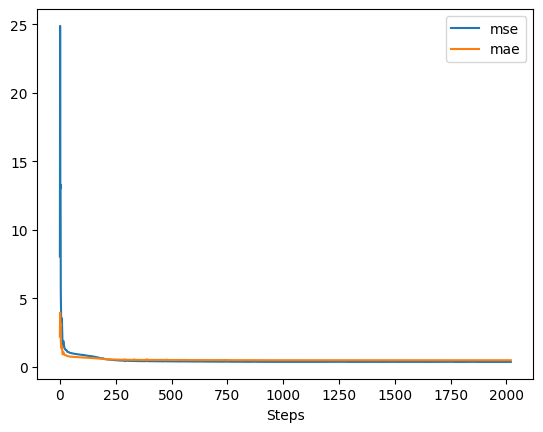

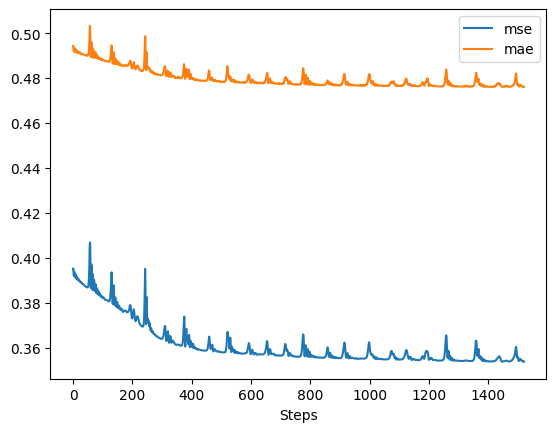

In [41]:
metric_list = np.array(metric_list)

plt.plot(metric_list[:,0], label="mse")
plt.plot(metric_list[:,1], label="mae")
#plt.plot(metric_list[:,2], label="maxae")
plt.legend()
plt.xlabel("Steps")
plt.show()

plt.plot(metric_list[500:,0], label="mse")
plt.plot(metric_list[500:,1], label="mae")
#plt.plot(metric_list[:,2], label="maxae")
plt.legend()
plt.xlabel("Steps")
plt.show()




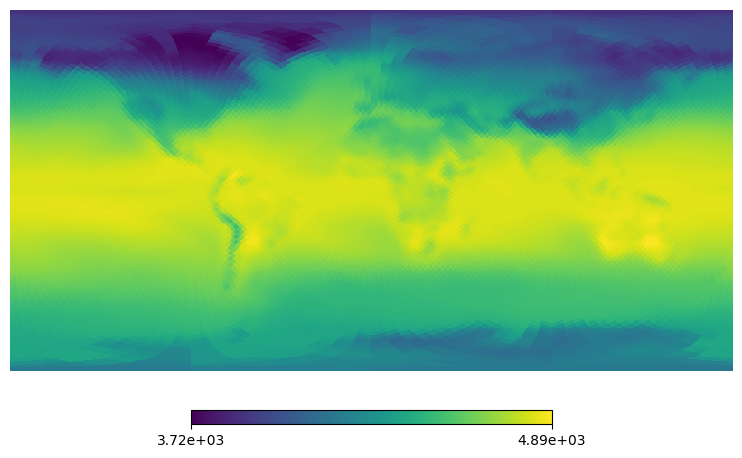

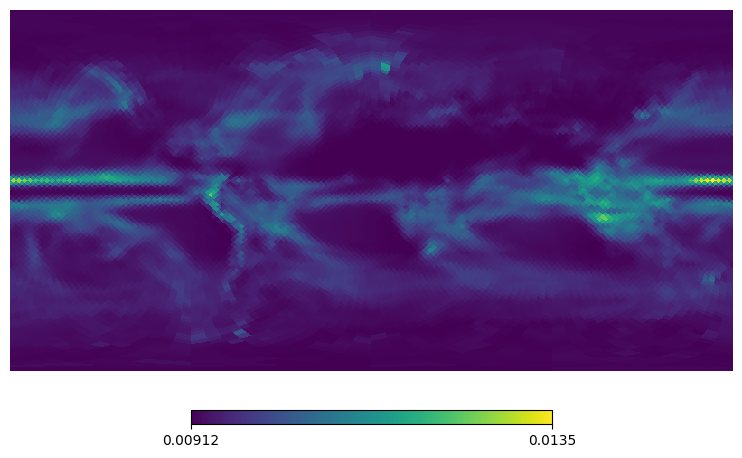

In [47]:
mean = output_stats["tas"]["mean"]
std = output_stats["tas"]["std"]
y_tr = y_true.squeeze() #.T
cpu_output = y_tr.cpu()

y_tr = cpu_output * std + mean

y_pr = y_pred.squeeze() #.T
y_pr = y_pr.cpu().detach()  * std + mean

healpix_plotting(y_tr.numpy())
healpix_plotting(y_pr.numpy())
healpix_plotting(y_pr.numpy() - y_tr.numpy())

## Two channel overfit test

In [19]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=2, n_upper=1)  # 2 outputs

learning_rate = 1e-3
model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)


# Get first sample from first batch
single_batch = {
    'input': batches[0]['input'][0:1],   # (1, 4, N) - just first sample
    'output': batches[0]['output'][0:1], # (1, 2, N) - just first sample
}

print(batches[0]['output'][0:1].shape)

model.train()
test_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
test_criterion = torch.nn.MSELoss()

print(f"Input shape: {single_batch['input'].shape}")
print(f"Output shape: {single_batch['output'].shape}")
metric_list = []
for step in range(8000):
    # Preprocess
    x_transformed, y_transformed = preprocess_batch(
        single_batch, input_stats, output_stats, input_vars, output_vars
    )
    
    x_tensor = torch.from_numpy(x_transformed).float().to(device)
    y_true = torch.from_numpy(y_transformed).float().to(device)
    
    # Forward
    test_optimizer.zero_grad()
    out = model({"input_surface": x_tensor})
    y_pred_raw = out["logits_surface"]
    
    # Handle shape
    if y_pred_raw.shape[1] > y_pred_raw.shape[2]:
        y_pred = y_pred_raw.permute(0, 2, 1)
    else:
        y_pred = y_pred_raw
    
    # Loss
    loss = test_criterion(y_pred, y_true)
    
    # Backward
    loss.backward()
    test_optimizer.step()
    
    # metrics
    mse = loss.item()
    mae = (y_pred - y_true).abs().mean().item()
    maxae = (y_pred - y_true).abs().max().item()
    metric_list.append([mse, mae, maxae])
    if step % 200 == 0:
        print(f"Step {step:3d} | MSE: {mse:.6e} | MAE: {mae:.6e} | MAXAE: {maxae:.6e}")


(1, 2, 12288)
Input shape: (1, 4, 12288)
Output shape: (1, 2, 12288)
Step   0 | MSE: 4.018096e+00 | MAE: 1.579468e+00 | MAXAE: 1.168207e+01
Step 200 | MSE: 3.212613e-01 | MAE: 3.881386e-01 | MAXAE: 6.461058e+00
Step 400 | MSE: 1.246765e-01 | MAE: 2.305619e-01 | MAXAE: 3.996562e+00
Step 600 | MSE: 6.045426e-02 | MAE: 1.695534e-01 | MAXAE: 3.186662e+00
Step 800 | MSE: 3.277143e-02 | MAE: 1.237399e-01 | MAXAE: 1.782647e+00
Step 1000 | MSE: 1.948076e-02 | MAE: 9.478192e-02 | MAXAE: 1.392955e+00
Step 1200 | MSE: 1.576715e-02 | MAE: 8.684146e-02 | MAXAE: 1.129228e+00
Step 1400 | MSE: 1.354514e-02 | MAE: 8.091787e-02 | MAXAE: 1.125790e+00
Step 1600 | MSE: 1.429956e-02 | MAE: 8.765011e-02 | MAXAE: 1.051047e+00
Step 1800 | MSE: 8.173070e-03 | MAE: 6.218972e-02 | MAXAE: 1.018453e+00
Step 2000 | MSE: 7.307716e-03 | MAE: 5.949722e-02 | MAXAE: 9.524423e-01
Step 2200 | MSE: 7.823007e-03 | MAE: 6.353148e-02 | MAXAE: 8.814170e-01
Step 2400 | MSE: 6.044833e-03 | MAE: 5.580853e-02 | MAXAE: 8.744278e-01


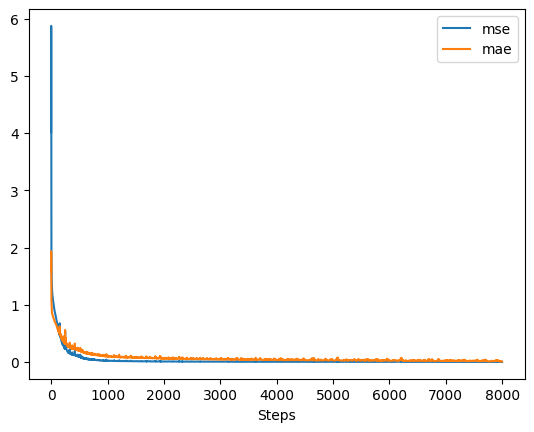

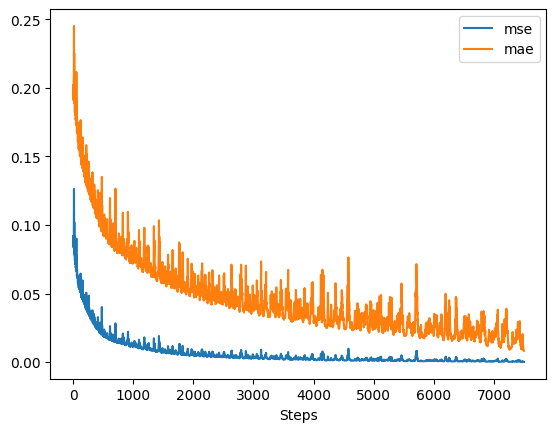

In [20]:
metric_list = np.array(metric_list)

plt.plot(metric_list[:,0], label="mse")
plt.plot(metric_list[:,1], label="mae")
#plt.plot(metric_list[:,2], label="maxae")
plt.legend()
plt.xlabel("Steps")
plt.show()

plt.plot(metric_list[500:,0], label="mse")
plt.plot(metric_list[500:,1], label="mae")
#plt.plot(metric_list[:,2], label="maxae")
plt.legend()
plt.xlabel("Steps")
plt.show()

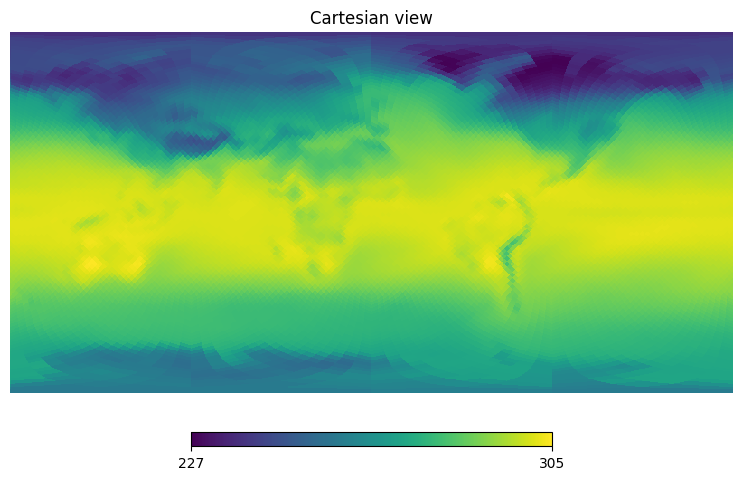

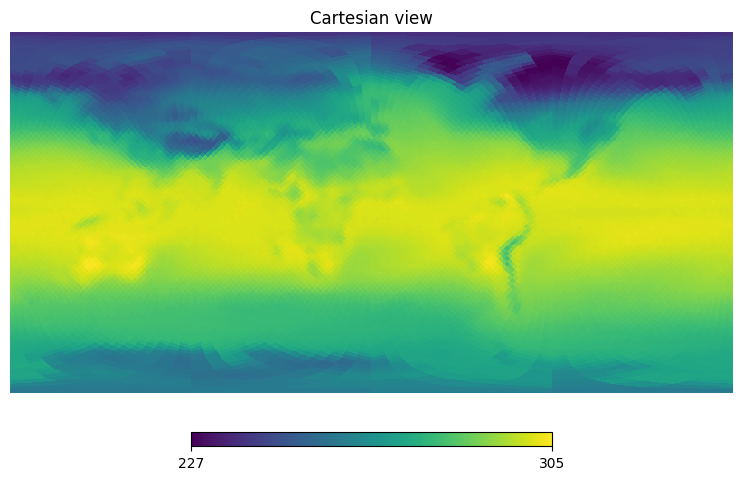

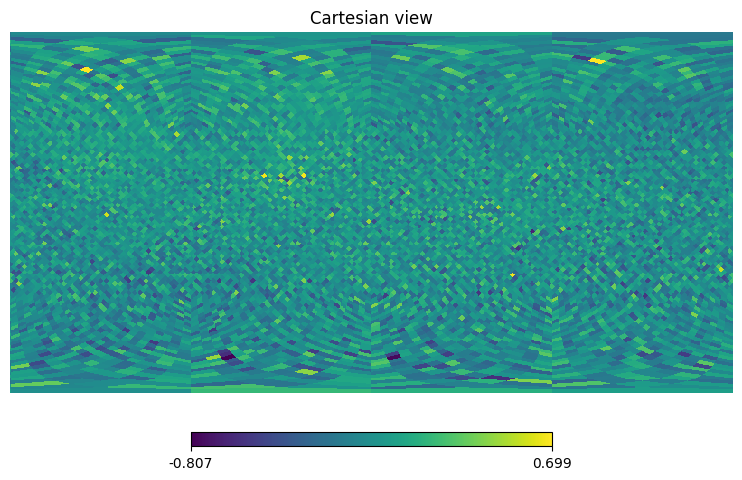

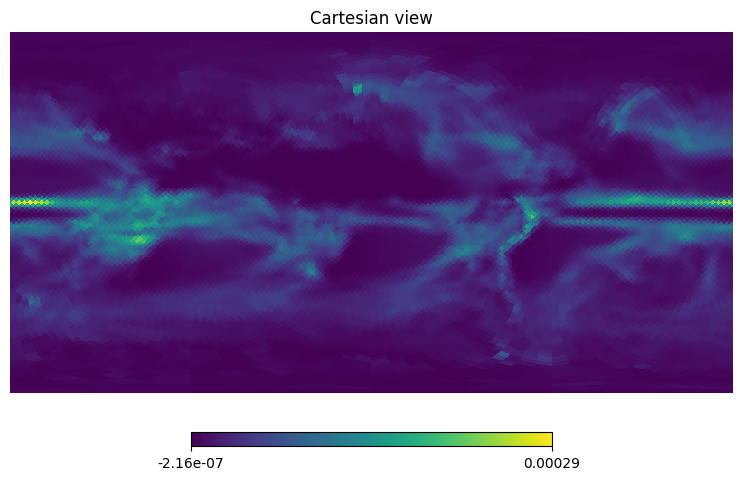

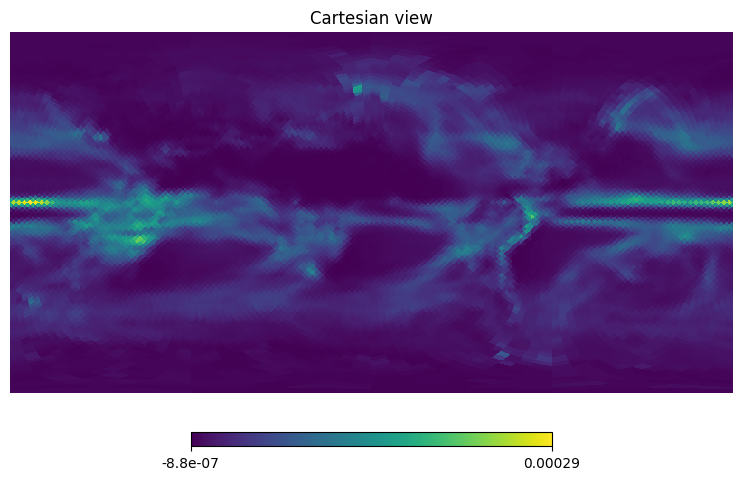

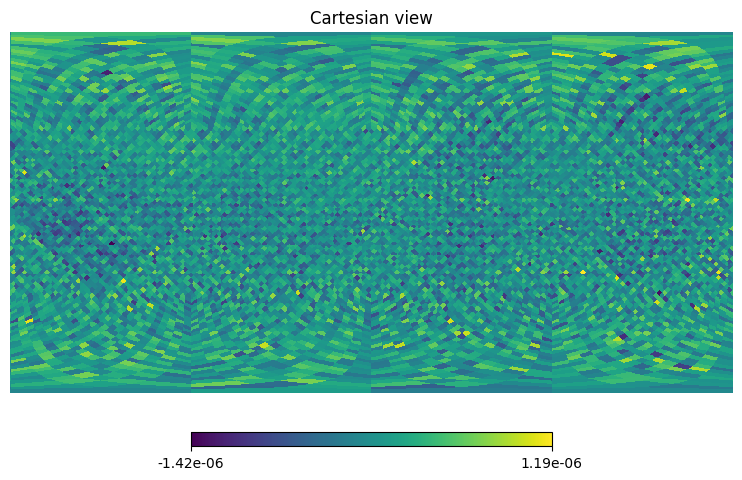

In [21]:
mean_tas = output_stats["tas"]["mean"]
std_tas = output_stats["tas"]["std"]
mean_pr = output_stats["pr"]["mean"]
std_pr = output_stats["pr"]["std"]

# y_true, y_pred: (1, 2, N)
y_t = y_true.squeeze(0).cpu()
y_p = y_pred.squeeze(0).cpu().detach()

# split channels
y_t_tas, y_t_pr = y_t[0], y_t[1]
y_p_tas, y_p_pr = y_p[0], y_p[1]

# destandardize
y_t_tas = y_t_tas * std_tas + mean_tas
y_p_tas = y_p_tas * std_tas + mean_tas

y_t_pr = y_t_pr * std_pr + mean_pr
y_p_pr = y_p_pr * std_pr + mean_pr

# plots
healpix_plotting(y_t_tas.numpy())
healpix_plotting(y_p_tas.numpy())
healpix_plotting((y_p_tas - y_t_tas).numpy())

healpix_plotting(y_t_pr.numpy())
healpix_plotting(y_p_pr.numpy())
healpix_plotting((y_p_pr - y_t_pr).numpy())

## Full model

In [41]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import (
    SwinHPClimatesetConfig,
    SwinHPClimateset,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- data spec ----
data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)
data_spec_output = DataSpecHP(nside=nside, n_surface=2, n_upper=1)

# ---- model ----
model_config = SwinHPClimatesetConfig(
    base_pix=12,
    nside=nside,
    dev_mode=False,
    depths=[2, 6, 6, 2],
    num_heads=[6, 12, 12, 6],
    embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
    window_size=[1, 64],
    use_cos_attn=False,
    use_v2_norm_placement=True,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.0,
    rel_pos_bias="single",
    shift_size=4,
    shift_strategy="ring_shift",
    ape=False,
    patch_size=16,
)

model = SwinHPClimateset(
    model_config,
    data_spec_input,
    data_spec_output,
).to(device)

# ---- optimizer / loss ----
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = torch.nn.MSELoss()

# ---- training ----
n_epochs = 200
model.train()

for epoch in range(n_epochs):
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(batches):
        x_batch = batch["input"]
        y_batch = batch["output"]

        x_transformed, y_transformed = preprocess_batch(
            batch, input_stats, output_stats, input_vars, output_vars
        )

        x_tensor = torch.from_numpy(x_transformed).float().to(device)
        y_true = torch.from_numpy(y_transformed).float().to(device)

        optimizer.zero_grad()
        out = model({"input_surface": x_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)

        loss = criterion(y_pred, y_true)
        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1e9)
        optimizer.step()

        epoch_loss += loss.item()

        # if batch_idx % 10 == 0:
        #     mae = (y_pred - y_true).abs().mean().item()
        #     print(
        #         f"Epoch {epoch+1:02d} | Batch {batch_idx:03d}/{len(batches)} "
        #         f"| Loss {loss.item():.6e} | MAE {mae:.6e} | GradNorm {grad_norm:.3e}"
        #     )

    print(
        f"Epoch {epoch+1:02d} done | Avg Loss: {epoch_loss / len(batches):.6e}"
    )


Epoch 01 done | Avg Loss: 1.650626e+00
Epoch 02 done | Avg Loss: 1.005486e+00
Epoch 03 done | Avg Loss: 9.430650e-01
Epoch 04 done | Avg Loss: 7.907501e-01
Epoch 05 done | Avg Loss: 6.767674e-01
Epoch 06 done | Avg Loss: 5.898012e-01
Epoch 07 done | Avg Loss: 6.791596e-01
Epoch 08 done | Avg Loss: 6.220081e-01
Epoch 09 done | Avg Loss: 5.062219e-01
Epoch 10 done | Avg Loss: 4.607527e-01
Epoch 11 done | Avg Loss: 4.257824e-01
Epoch 12 done | Avg Loss: 4.322293e-01
Epoch 13 done | Avg Loss: 3.937933e-01
Epoch 14 done | Avg Loss: 3.703561e-01
Epoch 15 done | Avg Loss: 3.655260e-01
Epoch 16 done | Avg Loss: 3.572504e-01
Epoch 17 done | Avg Loss: 3.435045e-01
Epoch 18 done | Avg Loss: 3.336215e-01
Epoch 19 done | Avg Loss: 3.254910e-01
Epoch 20 done | Avg Loss: 4.614583e-01
Epoch 21 done | Avg Loss: 4.104693e-01
Epoch 22 done | Avg Loss: 3.514903e-01
Epoch 23 done | Avg Loss: 3.281462e-01
Epoch 24 done | Avg Loss: 3.137487e-01
Epoch 25 done | Avg Loss: 3.013781e-01
Epoch 26 done | Avg Loss:

Validation loss: 1.498277e-01


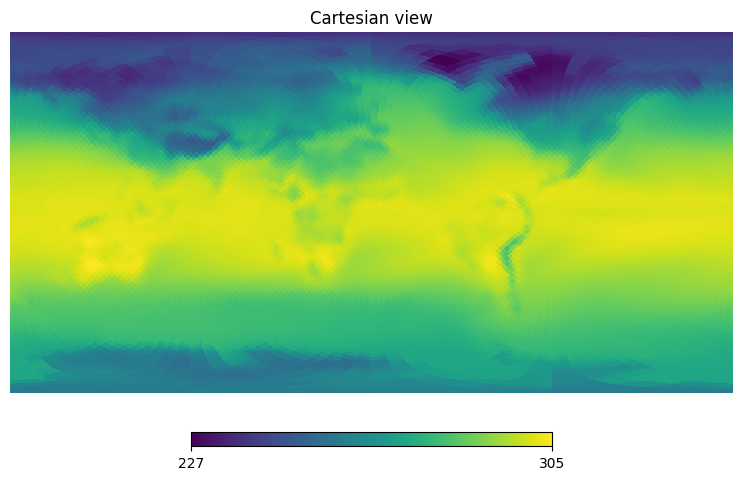

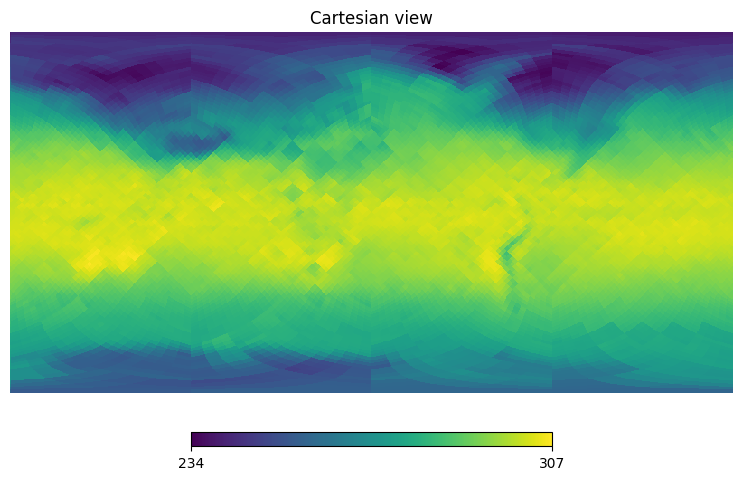

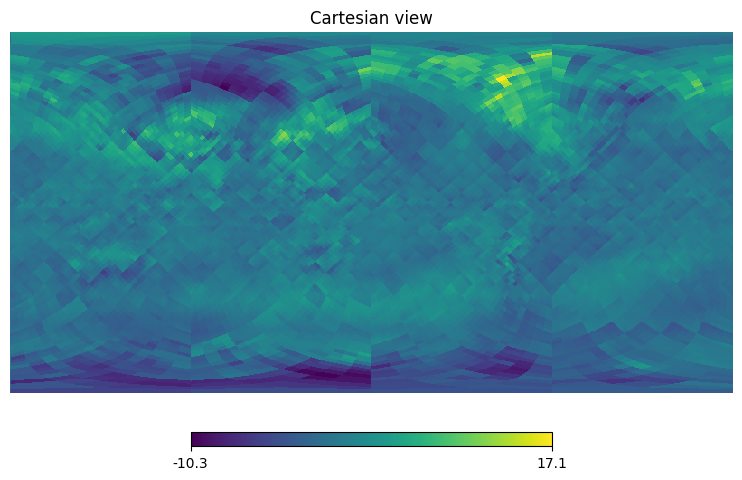

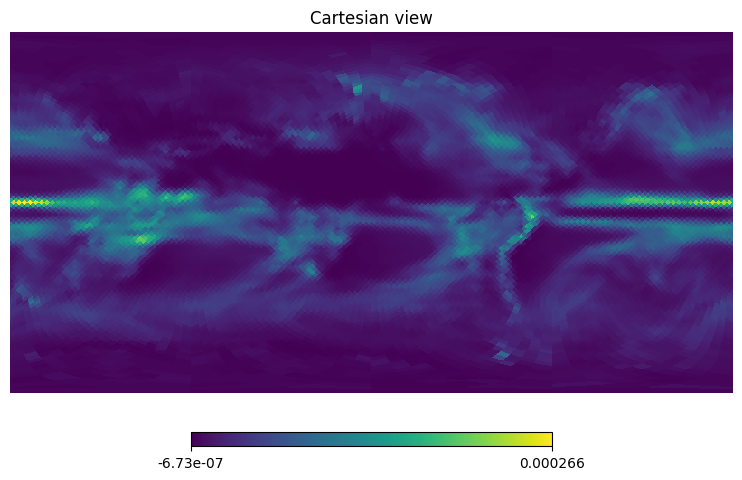

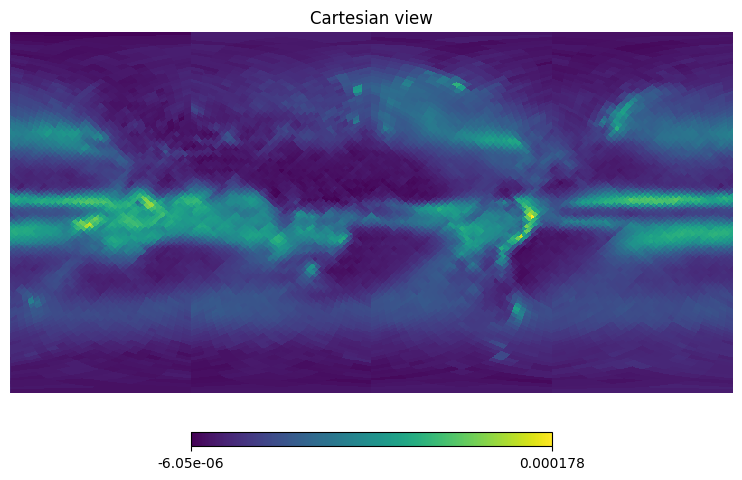

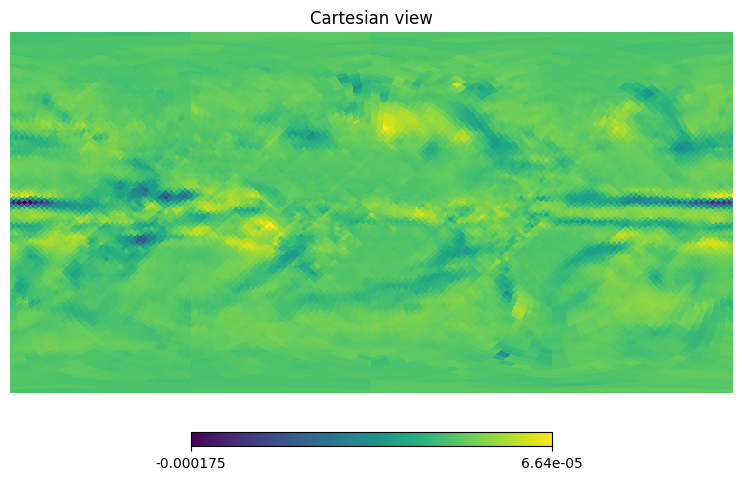

In [42]:
# ---- validation / evaluation ----
model.eval()
test_loss = 0.0

with torch.no_grad():
    for i, batch in enumerate(test_batches):
        # preprocess
        x_tr, y_tr = preprocess_batch(
            batch, input_stats, output_stats, input_vars, output_vars
        )

        x_tensor = torch.from_numpy(x_tr).float().to(device)
        y_true = torch.from_numpy(y_tr).float().to(device)

        # forward
        out = model({"input_surface": x_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)

        loss = criterion(y_pred, y_true)
        test_loss += loss.item()

        # ---- qualitative check on first batch only ----
        if i == 0:
            # take first sample in batch
            yt = y_true[0].cpu()
            yp = y_pred[0].cpu()

            # split channels (tas, pr)
            yt_tas, yt_pr = yt[0], yt[1]
            yp_tas, yp_pr = yp[0], yp[1]

            # destandardize
            yt_tas = yt_tas * output_stats["tas"]["std"] + output_stats["tas"]["mean"]
            yp_tas = yp_tas * output_stats["tas"]["std"] + output_stats["tas"]["mean"]

            yt_pr = yt_pr * output_stats["pr"]["std"] + output_stats["pr"]["mean"]
            yp_pr = yp_pr * output_stats["pr"]["std"] + output_stats["pr"]["mean"]

            # plots: truth / pred / residual
            healpix_plotting(yt_tas.numpy())#, title="TAS – truth")
            healpix_plotting(yp_tas.numpy())#, title="TAS – prediction")
            healpix_plotting((yp_tas - yt_tas).numpy())#, title="TAS – residual")

            healpix_plotting(yt_pr.numpy())#, title="PR – truth")
            healpix_plotting(yp_pr.numpy())#, title="PR – prediction")
            healpix_plotting((yp_pr - yt_pr).numpy())#, title="PR – residual")

avg_test_loss = test_loss / len(test_batches)
print(f"Validation loss: {avg_test_loss:.6e}")


### Evaluation

In [25]:
# Evaluate
model.eval()
test_loss = 0.0

plotting_test_samples = []
with torch.no_grad():
    for i, batch in enumerate(test_batches):
        x_batch = batch['input']
        x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
        x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
        
        y_true = x_batch_tensor
        
        out = model({"input_surface": x_batch_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        loss = criterion(y_pred, y_true)
        test_loss += loss.item()

        if i == 0:
            #x_batch_sample = batch['input'][0]
            #print(x_batch_tensor[0,:,:])
            #print(y_pred[0,:,:])

            inp = x_batch_tensor[0,:,:].squeeze() #.T
            cpu_input = inp.cpu()
            print(cpu_input, cpu_input.shape)
            x_co2, x_so2, x_ch4, x_bc = cpu_input
            
            output = y_pred[0,:,:].squeeze() #.T
            cpu_output = output.cpu()
            y_co2, y_so2, y_ch4, y_bc = cpu_output

            y_sanity_check = y_pred[7,:,:].squeeze() #.T
            y_cpu_sanity = y_sanity_check.cpu()
            ys_co2, ys_so2, ys_ch4, ys_bc = y_cpu_sanity

            x_sanity_check = x_batch_tensor[7,:,:].squeeze() #.T
            x_cpu_sanity = x_sanity_check.cpu()
            xs_co2, xs_so2, xs_ch4, xs_bc = x_cpu_sanity
            #healpix_plotting(np.array(co2))
            # healpix_plotting(x_co2.numpy())
            # healpix_plotting(y_co2.detach().numpy())
            healpix_plotting(s_co2.detach().numpy())
            
            # diff = x_co2.numpy() - y_so2.detach().numpy()
            # healpix_plotting(np.abs(diff))
            diff2 = x_co2.numpy() - ys_co2.detach().numpy()
            healpix_plotting(np.abs(diff2))
            diff = x_co2.numpy() - y_co2.detach().numpy()
            healpix_plotting(np.abs(diff))
            
#avg_test_loss = test_loss / len(test_batches)
print(f"Test Loss on {test_experiments}: {avg_test_loss:.6e}")




NameError: name 'test_batches' is not defined

In [ ]:

    
.detach()
input_v = input_v.squeeze()
print(input_v)
cpu_input_v = input_v.cpu()
inp_co2, inp_so2, inp_ch4, inp_bc = cpu_input_v

output = out["logits_surface"]
output = output.squeeze().T
cpu_output = output.cpu()
co2, so2, ch4, bc = cpu_output

#healpix_plotting(np.array(co2))
healpix_plotting(inp_co2.numpy())
healpix_plotting(co2.detach().numpy())

diff = inp_co2.numpy() - co2.detach().numpy()
healpix_plotting(np.abs(diff))

## Train / Test regular prediction model

In [12]:
from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=1, n_upper=1)  # 1 output temperature

model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)



In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
n_epochs = 5

print("\nStarting training...")
for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    # Shuffle batches each epoch (optional)
    if shuffle:
        import random
        random.shuffle(batches)
    
    for batch in batches:
        # Get batch data
        x_batch = batch['input']  # (B, C, N)
        
        # Apply transform
        x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
        
        # Convert to torch and move to device
        x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
        
        # Target (for autoencoding, same as input)
        y_batch = batch['output']
        y_batch_scaled = apply_log_transform(y_batch, global_mean, global_std)
        y_true = torch.from_numpy(y_batch_scaled).float().to(device)
        
    
        # Forward pass
        optimizer.zero_grad()
        out = model({"input_surface": x_batch_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        # Compute loss
        loss = criterion(y_pred, y_true)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Print batch info
        batch_idx = batch['batch_idx']
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Batch {batch_idx}/{len(batches)} | "
                  f"Loss: {loss.item():.6e} | "
                  f"Sample exp: {batch['metadata'][0]['exp']}")
    
    avg_loss = epoch_loss / len(batches)
    print(f"\n==> Epoch {epoch+1} complete | Avg Loss: {avg_loss:.6e}\n")
print("done")


Starting training...
Epoch 1/5 | Batch 0/387 | Loss: 7.510012e+01 | Sample exp: ssp585
Epoch 1/5 | Batch 10/387 | Loss: 1.515435e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 20/387 | Loss: 4.000920e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 30/387 | Loss: 1.844546e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 40/387 | Loss: 1.172283e-01 | Sample exp: ssp585
Epoch 1/5 | Batch 50/387 | Loss: 6.452098e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 60/387 | Loss: 5.056745e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 70/387 | Loss: 4.459184e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 80/387 | Loss: 3.995191e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 90/387 | Loss: 3.639906e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 100/387 | Loss: 3.359662e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 110/387 | Loss: 3.148688e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 120/387 | Loss: 2.973427e-02 | Sample exp: ssp585
Epoch 1/5 | Batch 130/387 | Loss: 4.819433e-02 | Sample exp: ssp126
Epoch 1/5 | Batch 140/387 | Loss: 3.4

tensor([[-0.1627,  0.0428,  0.2074,  ...,  0.1711,  0.2038, -0.1107],
        [ 0.7824,  0.9901,  1.1887,  ...,  1.0787,  1.1592,  0.8088],
        [-0.1886, -0.0688, -0.0266,  ...,  0.4620,  0.4611,  0.2116],
        [ 0.9954,  1.0174,  1.1403,  ...,  1.7649,  1.8060,  1.4756]]) torch.Size([4, 12288])
Test Loss: 1.683289e-03


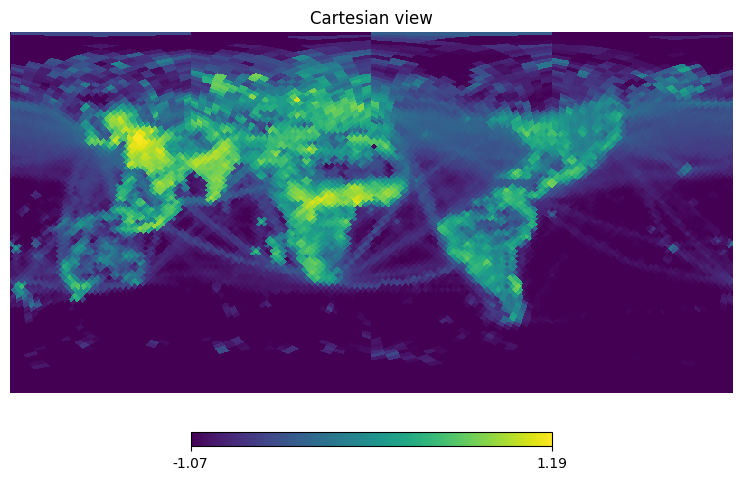

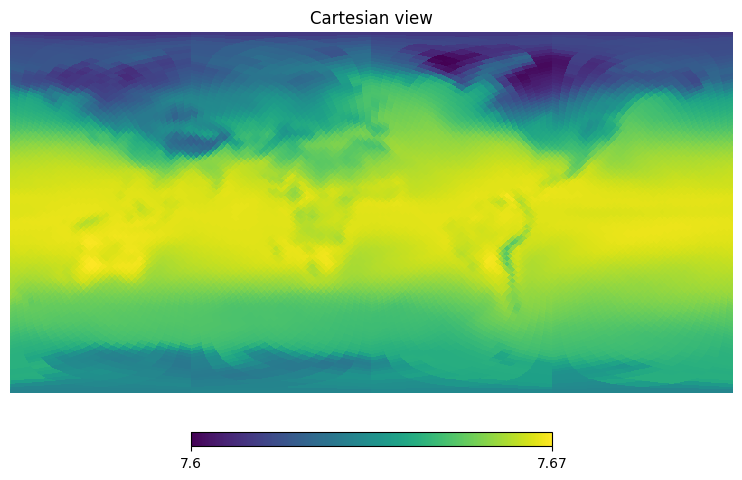

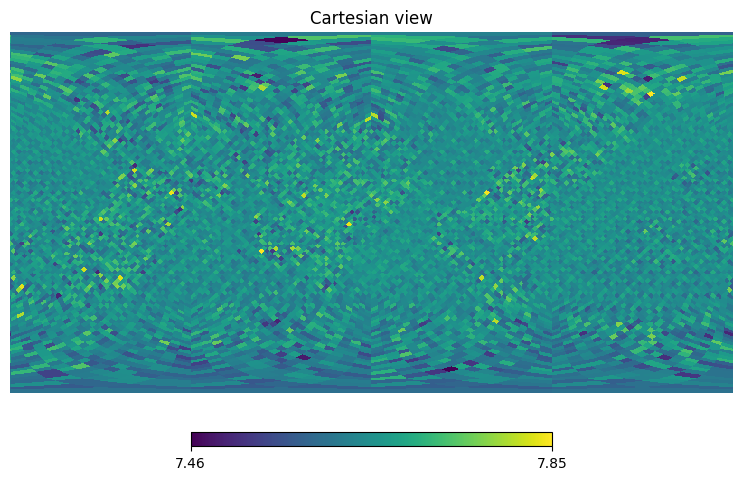

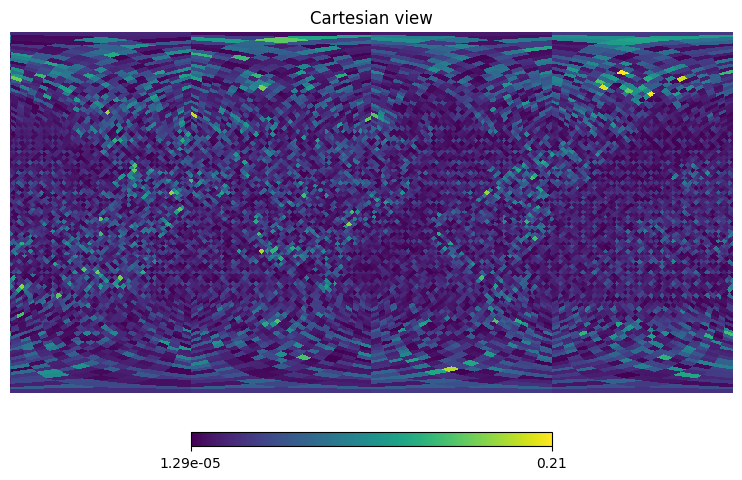

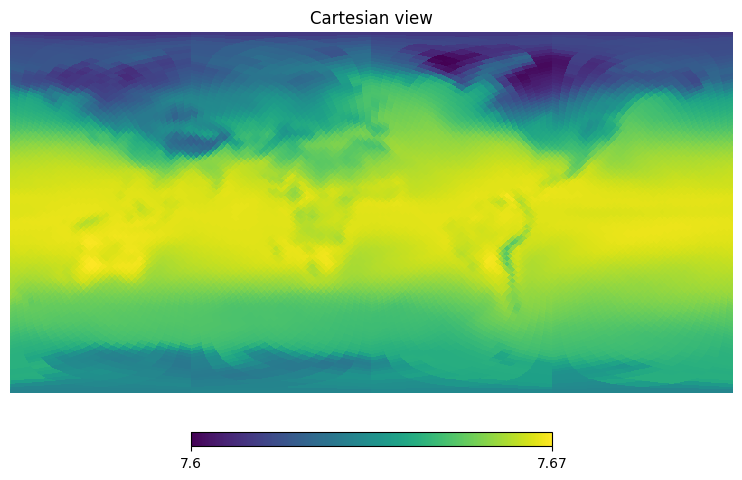

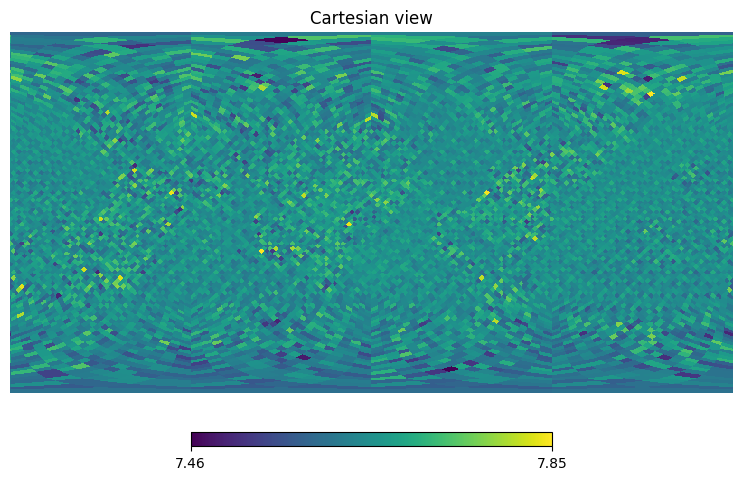

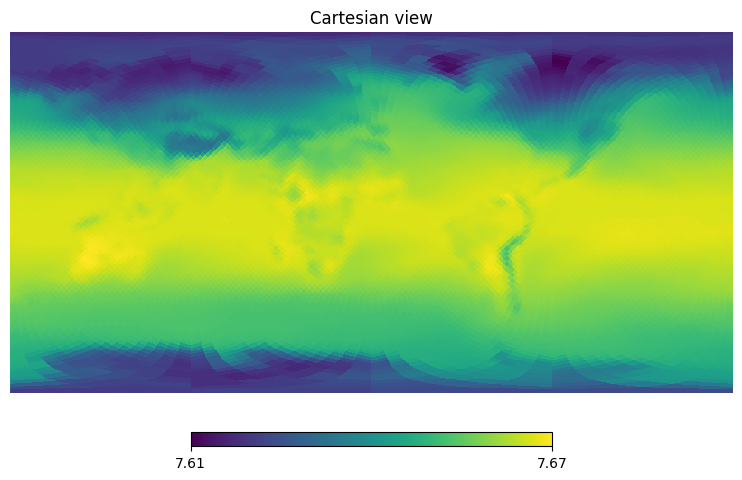

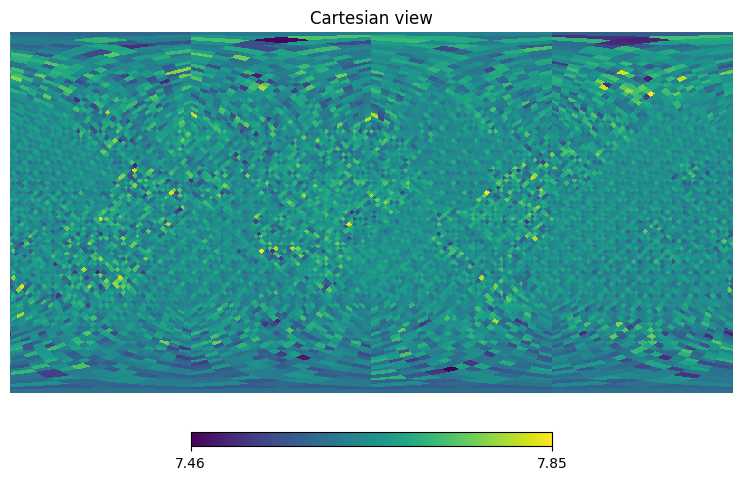

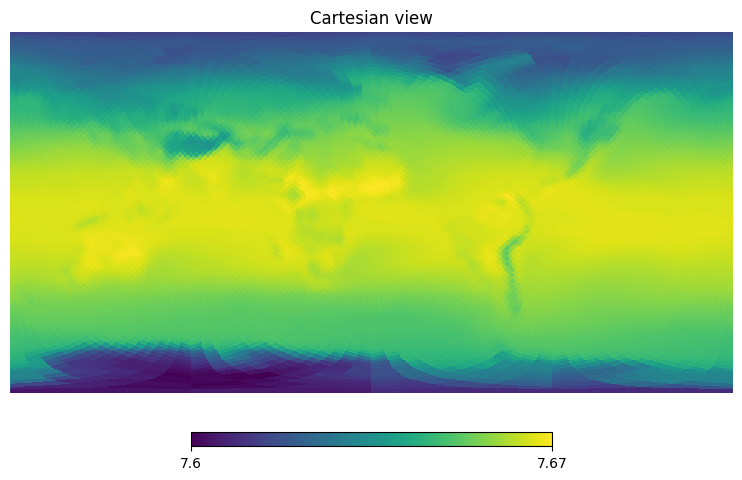

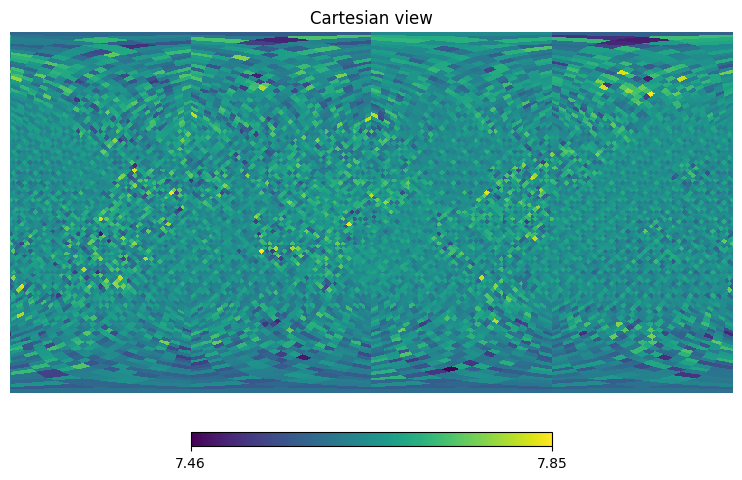

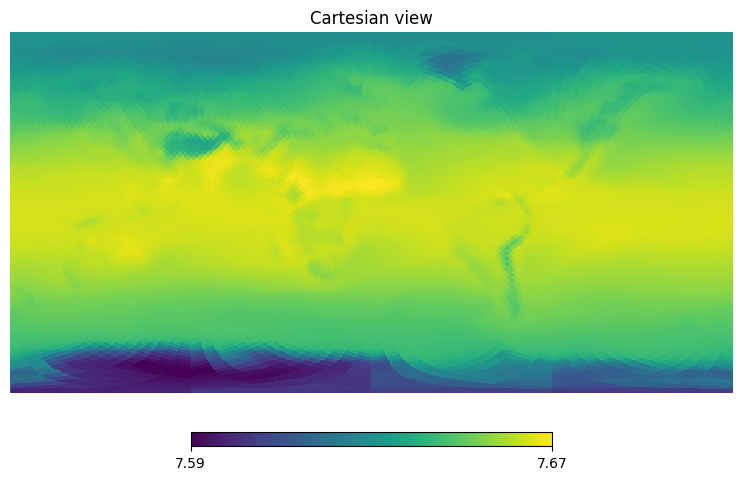

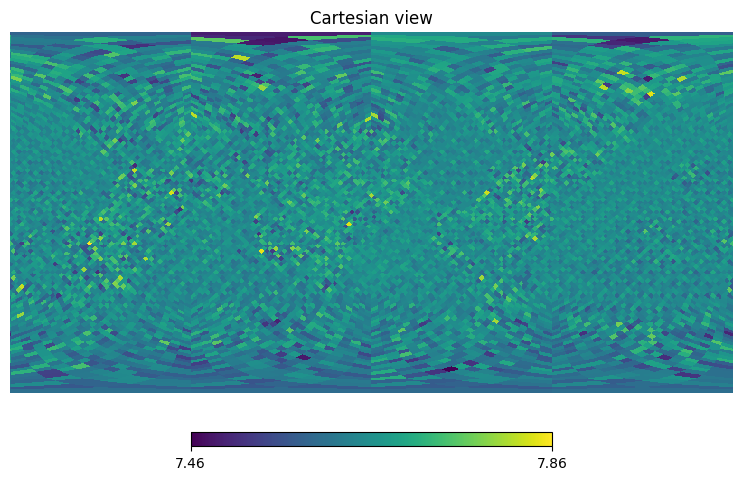

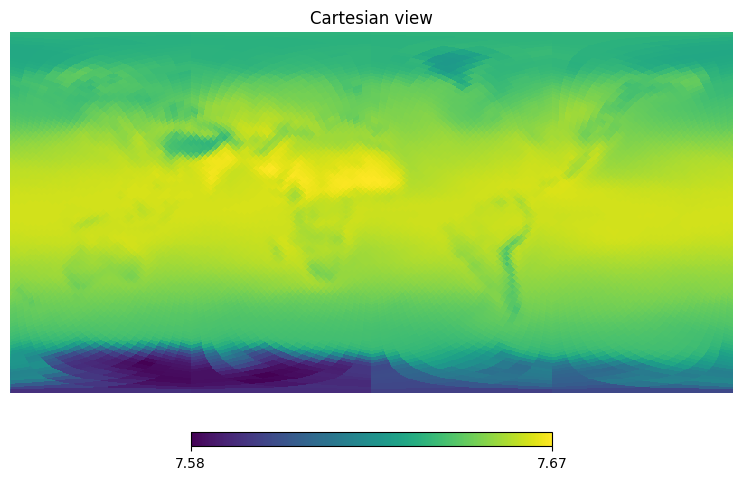

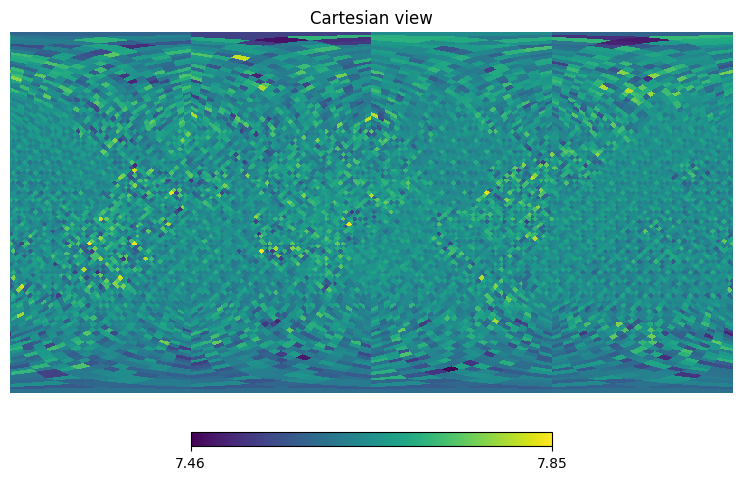

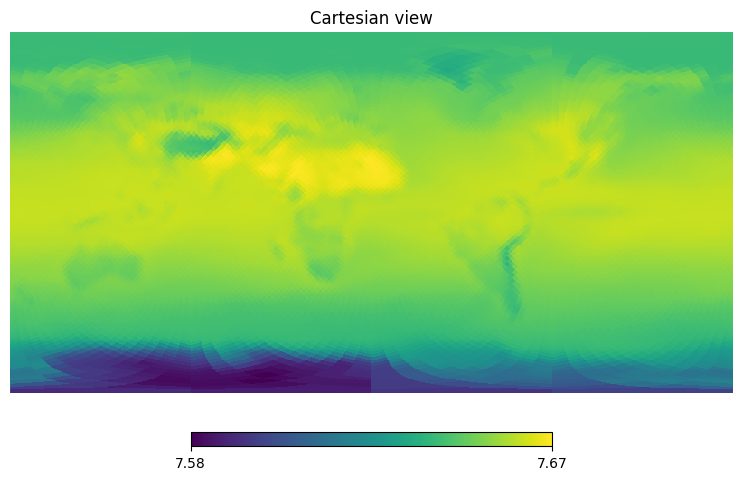

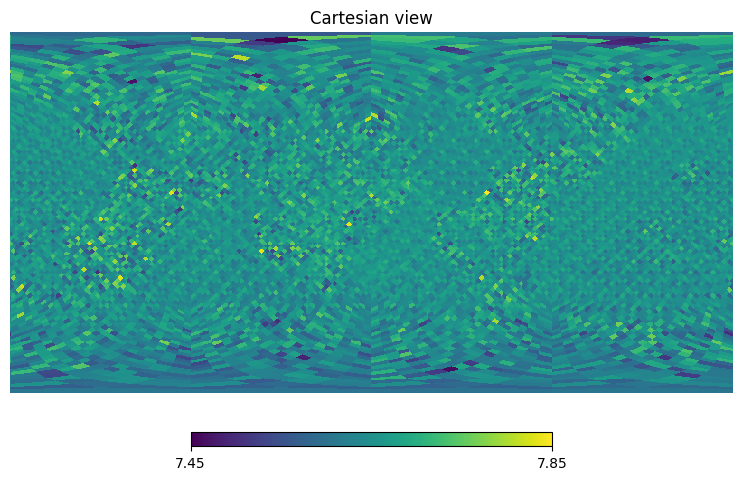

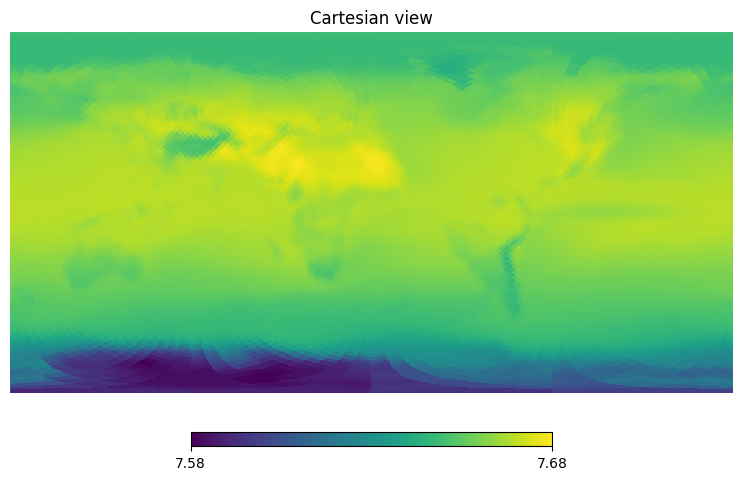

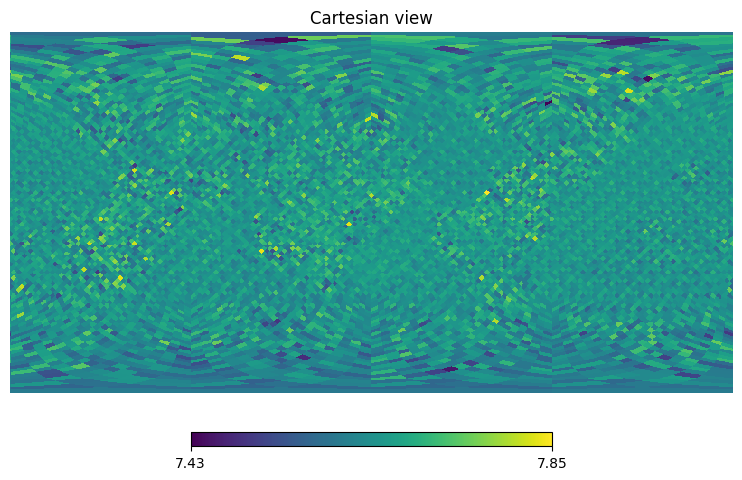

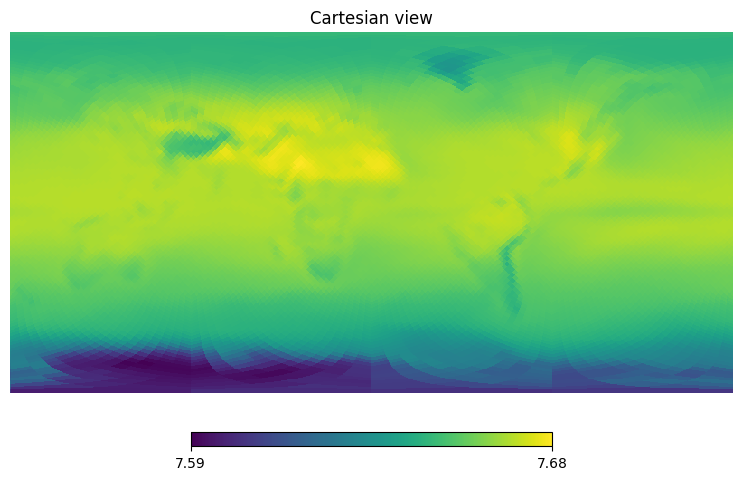

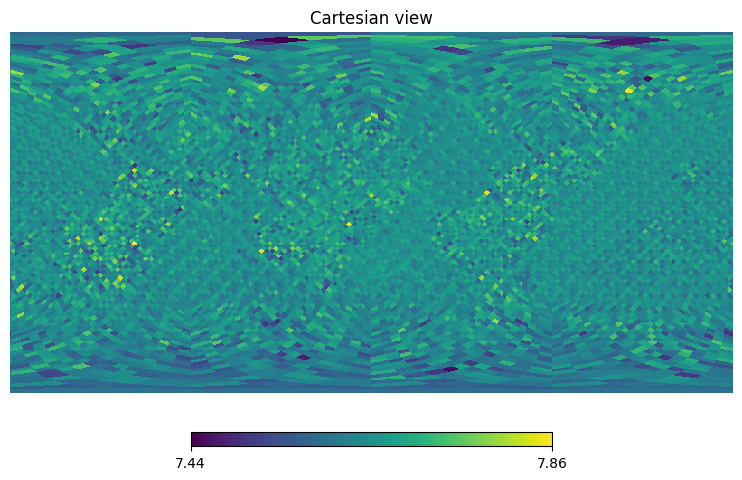

In [16]:
def evaluate(model, test_batches, global_mean, global_std, criterion, device):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_batches):
            # Input: 4 gases
            x_batch = batch['input']
            x_batch_scaled = apply_log_transform(x_batch, global_mean, global_std)
            x_batch_tensor = torch.from_numpy(x_batch_scaled).float().to(device)
            
            # Target: temperature (or whatever outputs you have)
            y_batch = batch['output']
            y_batch_scaled = apply_log_transform(y_batch, global_mean, global_std)
            y_true = torch.from_numpy(y_batch_scaled).float().to(device)
            
            # Forward
            out = model({"input_surface": x_batch_tensor})
            y_pred = out["logits_surface"].permute(0, 2, 1)
            
            # Loss
            loss = criterion(y_pred, y_true)
            test_loss += loss.item()
            
            # Store for analysis (optional)
            all_preds.append(y_pred.cpu())
            all_targets.append(y_true.cpu())

            
            if i == 0:
                #x_batch_sample = batch['input'][0]
                #print(x_batch_tensor[0,:,:])
                #print(y_pred[0,:,:])
    
                inp = x_batch_tensor[0,:,:].squeeze() #.T
                cpu_input = inp.cpu()
                print(cpu_input, cpu_input.shape)
                x_co2, x_so2, x_ch4, x_bc = cpu_input
                
                output = y_true[0,:,:].squeeze() #.T
                cpu_output = output.cpu()
                y_tr = cpu_output
    
                y_pr = y_pred[0,:,:].squeeze() #.T
                y_pr = y_pr.cpu()
                #ys_co2 = y_cpu_sanity
    
                # x_sanity_check = x_batch_tensor[7,:,:].squeeze() #.T
                # x_cpu_sanity = x_sanity_check.cpu()
                # xs_co2, xs_so2, xs_ch4, xs_bc = x_cpu_sanity
                #healpix_plotting(np.array(co2))
                
                healpix_plotting(x_co2.numpy())
                healpix_plotting(y_tr.numpy())
                healpix_plotting(y_pr.numpy())
                diff = y_tr.numpy() - y_pr.detach().numpy()
                healpix_plotting(np.abs(diff))
                # healpix_plotting(y_co2.detach().numpy())
                # healpix_plotting(s_co2.detach().numpy())
                
                # # diff = x_co2.numpy() - y_so2.detach().numpy()
                # # healpix_plotting(np.abs(diff))
                # diff2 = x_co2.numpy() - ys_co2.detach().numpy()
                # healpix_plotting(np.abs(diff2))
                # diff = x_co2.numpy() - y_co2.detach().numpy()
                # healpix_plotting(np.abs(diff))

                for i in range(0, batch_size):
                    output = y_true[i,:,:].squeeze() #.T
                    cpu_output = output.cpu()
                    y_tr = cpu_output
        
                    y_pr = y_pred[i,:,:].squeeze() #.T
                    y_pr = y_pr.cpu()
                    healpix_plotting(y_tr.numpy())
                    healpix_plotting(y_pr.numpy())

    avg_test_loss = test_loss / len(test_batches)
    print(f"Test Loss: {avg_test_loss:.6e}")
    
    return avg_test_loss, all_preds, all_targets

# Use it:
test_loss, preds, targets = evaluate(model, test_batches, global_mean, global_std, criterion, device)

In [19]:
# ============================================================================
# COMPUTE SEPARATE STATISTICS FOR INPUTS AND OUTPUTS
# ============================================================================

from experiments.weather.data import DataSpecHP
from experiments.climate.models.swin_hp_climateset import SwinHPClimatesetConfig
from experiments.climate.models.swin_hp_climateset import SwinHPClimateset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_spec_input = DataSpecHP(nside=nside, n_surface=4, n_upper=1)  # 4 input gases
data_spec_output = DataSpecHP(nside=nside, n_surface=1, n_upper=1)  # 1 output temperature

model_config = SwinHPClimatesetConfig(
            base_pix=12,
            nside=nside,
            dev_mode=False,
            depths=[2, 6, 6, 2],
            # num_heads=[6, 12, 12, 6],
            num_heads=[6, 12, 12, 6],
            # embed_dims=[192, 384, 384, 192],
            embed_dims=[192 // 4, 384 // 4, 384 // 4, 192 // 4],
            # embed_dims=[16, 384 // 16, 384 // 16, 192 // 16],
            # embed_dims=[x for x in [16, 32, 32, 16]],
            window_size=[1, 64],  # <----- CHANGED
            use_cos_attn=False,
            use_v2_norm_placement=True,
            drop_rate=0,  # ,0.1,
            attn_drop_rate=0,  # ,0.1,
            drop_path_rate=0,
            rel_pos_bias="single",
            # shift_size=8,  # int(16 * (NSIDE / 256)),
            # shift_size=4,  # int(16 * (NSIDE / 256)),
            shift_size= 4,
            shift_strategy="ring_shift",
            ape=False,
            patch_size=16,
        )
shuffle = False

model = SwinHPClimateset(
    model_config, 
    data_spec_input,
    data_spec_output
).to(device)

# Input statistics (gases - use log scaling)
all_inputs_log = np.log10(np.clip(all_inputs, 1e-15, None) + 1e-15)
input_mean = all_inputs_log.mean()
input_std = all_inputs_log.std()

# Output statistics (temperature - NO log, just standardize)
all_outputs_flat = all_outputs.flatten()
output_mean = all_outputs_flat.mean()
output_std = all_outputs_flat.std()

print(f"Input (log gases): mean={input_mean:.6f}, std={input_std:.6f}")
print(f"Output (temperature): mean={output_mean:.6f}, std={output_std:.6f}")

# ============================================================================
# SEPARATE TRANSFORM FUNCTIONS
# ============================================================================

def transform_inputs(data, mean, std, eps=1e-12):
    """Log transform for gas concentrations"""
    data_log = np.log10(np.clip(data, 1e-15, None) + 1e-15)
    return (data_log - mean) / max(std, eps)

def transform_outputs(data, mean, std, eps=1e-12):
    """Simple standardization for temperature"""
    return (data - mean) / max(std, eps)

# ============================================================================
# TRAINING LOOP - USE BOTH TRANSFORMS
# ============================================================================


Input (log gases): mean=-12.587745, std=1.965315
Output (temperature): mean=289.597046, std=15.076720


In [20]:
model.train()
for epoch in range(n_epochs):
    for batch in batches:
        # Transform inputs (gases with log)
        x_batch = batch['input']
        x_scaled = transform_inputs(x_batch, input_mean, input_std)
        x_tensor = torch.from_numpy(x_scaled).float().to(device)
        
        # Transform outputs (temperature without log)
        y_batch = batch['output']
        y_scaled = transform_outputs(y_batch, output_mean, output_std)
        y_true = torch.from_numpy(y_scaled).float().to(device)
        
        # Forward pass
        optimizer.zero_grad()
        out = model({"input_surface": x_tensor})
        y_pred = out["logits_surface"].permute(0, 2, 1)
        
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        
        # Print batch info
        batch_idx = batch['batch_idx']
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Batch {batch_idx}/{len(batches)} | "
                  f"Loss: {loss.item():.6e} | "
                  f"Sample exp: {batch['metadata'][0]['exp']}")
    
    avg_loss = epoch_loss / len(batches)
    print(f"\n==> Epoch {epoch+1} complete | Avg Loss: {avg_loss:.6e}\n")

Epoch 1/5 | Batch 0/387 | Loss: 7.477867e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 50/387 | Loss: 6.774795e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 100/387 | Loss: 6.812660e+00 | Sample exp: ssp585
Epoch 1/5 | Batch 150/387 | Loss: 7.353149e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 200/387 | Loss: 7.051984e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 250/387 | Loss: 7.046974e+00 | Sample exp: ssp126
Epoch 1/5 | Batch 300/387 | Loss: 7.169533e+00 | Sample exp: ssp370
Epoch 1/5 | Batch 350/387 | Loss: 6.795452e+00 | Sample exp: ssp370

==> Epoch 1 complete | Avg Loss: 1.787862e-03

Epoch 2/5 | Batch 0/387 | Loss: 7.477867e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 50/387 | Loss: 6.774795e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 100/387 | Loss: 6.812660e+00 | Sample exp: ssp585
Epoch 2/5 | Batch 150/387 | Loss: 7.353149e+00 | Sample exp: ssp126
Epoch 2/5 | Batch 200/387 | Loss: 7.051984e+00 | Sample exp: ssp126
Epoch 2/5 | Batch 250/387 | Loss: 7.046974e+00 | Sample exp: ssp126
Epoch 

In [21]:

# ============================================================================
# EVALUATION - SAME SEPARATE TRANSFORMS
# ============================================================================

def evaluate(model, test_batches, input_mean, input_std, output_mean, output_std, criterion, device):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch in test_batches:
            x_batch = transform_inputs(batch['input'], input_mean, input_std)
            x_tensor = torch.from_numpy(x_batch).float().to(device)
            
            y_batch = transform_outputs(batch['output'], output_mean, output_std)
            y_true = torch.from_numpy(y_batch).float().to(device)
            
            out = model({"input_surface": x_tensor})
            y_pred = out["logits_surface"].permute(0, 2, 1)
            
            loss = criterion(y_pred, y_true)
            test_loss += loss.item()
    
    return test_loss / len(test_batches)

# Call it with both sets of statistics
test_loss = evaluate(model, test_batches, input_mean, input_std, 
                     output_mean, output_std, criterion, device)

In [22]:
test_loss

7.153786670329959